In [27]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
from sklearn import metrics

params = {'axes.labelsize': 12,
          'axes.titlesize': 12}
plt.rcParams.update(params)

def remove_self_cos(x):
    #print ("removing self 1")
    new_x = []
    size = x.shape[1]
    for i in range(3*size):
        idx = i%500
        new_line = []
        new_line = np.concatenate((x[i][:idx],x[i][idx+1:]),axis=0)
        new_line = np.reshape(new_line,(-1))
        #print (new_line.shape)
        new_x.append(new_line)
        
    new_x = np.array(new_x)
    #print (new_x.shape)
    return new_x
    

def mmd_distance(x,y):
    #x = np.reshape(x,(-1,1))
    #y = np.reshape(y,(-1,1))
    #return [mmd_linear(x,y),mmd_poly(x,y),mmd_rbf(x,y)]
    
    #print (x.shape,y.shape)
    
    from scipy import stats
    return stats.ks_2samp(x,y)[0]

def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def report_acc(data,label):
    
    unique_labels = np.unique(label)
    train_index = []
    for this_label in unique_labels:
        this_class_index = np.arange(len(label))[label == this_label]
        this_class_train_index = np.random.choice(this_class_index,int(len(this_class_index)/2),replace=False)
        train_index.append(this_class_train_index)
    
    #train_index = np.random.choice(len(label),int(len(label)/2),replace=False)
    test_index = np.setdiff1d(np.arange(len(label)),train_index)

    train_data = data[train_index]
    train_label = label[train_index]
    test_data = data[test_index]
    test_label = label[test_index]

    train_data = np.reshape(train_data, (len(train_label), -1))
    test_data = np.reshape(test_data, (len(test_label),-1))

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import balanced_accuracy_score
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    clf = LogisticRegression(random_state=0, solver='liblinear',class_weight='balanced')
    clf.fit(train_data, train_label)
    #print (" attack accuracy %.2f" % (clf.score(test_data, test_label) * 100))
    acc1 = balanced_accuracy_score(test_label,clf.predict(test_data))
    #print (classification_report(test_label,clf.predict(test_feature)))
    auc1 = roc_auc_score(test_label,clf.predict(test_data))
    f1_1 = f1_score(test_label,clf.predict(test_data), average='weighted')

    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100,max_depth=30, random_state=0,class_weight="balanced")
    
    #from sklearn.svm import SVC
    #clf = SVC(gamma='auto')
    
    #from sklearn.neural_network import MLPClassifier
    #lf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(10,5), random_state=1,max_iter=100)
    
    
    clf.fit(train_data, train_label)
    acc2 = balanced_accuracy_score(test_label,clf.predict(test_data))
    auc2 = roc_auc_score(test_label,clf.predict(test_data))
    f1_2 = f1_score(test_label,clf.predict(test_data), average='weighted')
    #print (classification_report(test_label,mode.predict(test_feature)))
    #print ("balanced accuracy",max(acc1,acc2))
    #print ("roc-auc",max(auc1,auc2))
    #print ("f1 score",max(f1_1,f1_2))

    return max(acc1,acc2)
    #max(auc1,auc2)
    #max(f1_1,f1_2)

def report_auc(data,label):
    #print ("report auc")
    #print (data.shape)
    #print (label.shape)
    
    if (len(data.shape)==1):
        from sklearn.metrics import roc_auc_score
        y_true = label
        y_pred = np.squeeze(data)
        #print ("AUC score", roc_auc_score(-1*y_true, y_pred))
        return roc_auc_score(y_true,y_pred)
    else:
        ### 
        pass
    
def normalization(data):
    data = (data - np.average(data))/np.std(data)
    return data

def processing_batch(data):
    #num_batches = data.shape[0]
    #print (data.shape)
    num_instances = data.shape[0]
    num_layers = data.shape[1]
    num_features = data.shape[2]
    #data = np.reshape(data,(-1,num_layers,num_features))
    
    
    ### features in data: 0. cos 1. |B*n|_L1 2.|b*n-a|_L1 3.|a|_L1 4.L2 of 1 5.L2 of 2 6.L2 of 3  
    ###                   7. pos_sign(param1_ground) 8.neg_sign(param1_ground) 9. pos_sign(param2_ground) 10.neg_sign(param2_ground)
    ###                   11. pos_sign(counting) 12.neg_sign(counting) 13. sum_counting
    ### sparse feat above 14.     15.          16.         17.      18.       19.       20.     
    ###                   21.                        22.                       23.                         24.
    ###                   25.                    26.                   27.
    ### 
    
    ### we have 5 features here: 0. cos 1. |b*n|-|b*n-a| L1 2. |b*n|-|b*n-a| L2 3. |a| L1 4. |a| L2 5. pos_sign(a-ground) 
    ###                          6.neg_sign(a-ground) 7.pos_sign(b_ground) 8.neg_sign(b_ground) 9. pos_sign(counting) 
    ###                          10.neg_sign(counting) 11. sum_counting
    ### 12 for normal
    ### 12 for sparse
    ### this function is subject to change because we may have other ways to process the information from multiple batches
    
    generated_features = np.zeros((num_instances,num_layers,24))
    
    for i in range(num_instances):
        this_instance_data = data[i,:,:]
        
        for j in range(num_layers):
            generated_features[i,j,0] = this_instance_data[j,0]
            generated_features[i,j,3] = this_instance_data[j,3]
            generated_features[i,j,4] = this_instance_data[j,6]
            generated_features[i,j,1] = this_instance_data[j,1]-this_instance_data[j,2]
            generated_features[i,j,2] = this_instance_data[j,4]-this_instance_data[j,5]
            generated_features[i,j,5] = this_instance_data[j,7]
            generated_features[i,j,6] = this_instance_data[j,8]
            generated_features[i,j,7] = this_instance_data[j,9]
            generated_features[i,j,8] = this_instance_data[j,10]
            generated_features[i,j,9] = this_instance_data[j,11]
            generated_features[i,j,10] = this_instance_data[j,12]
            generated_features[i,j,11] = this_instance_data[j,13]

            generated_features[i,j,12] = this_instance_data[j,14]
            generated_features[i,j,15] = this_instance_data[j,17]
            generated_features[i,j,16] = this_instance_data[j,20]
            generated_features[i,j,13] = this_instance_data[j,15]-this_instance_data[j,16]
            generated_features[i,j,14] = this_instance_data[j,18]-this_instance_data[j,19]
            generated_features[i,j,17] = this_instance_data[j,21]
            generated_features[i,j,18] = this_instance_data[j,22]
            generated_features[i,j,19] = this_instance_data[j,23]
            generated_features[i,j,20] = this_instance_data[j,24]
            generated_features[i,j,21] = this_instance_data[j,25]
            generated_features[i,j,22] = this_instance_data[j,26]
            generated_features[i,j,23] = this_instance_data[j,27]
            
    ### we can normalize the cosine and the norm per layer 
    
    #for j in range(num_layers):
    #    cos_normalized = normalization(generated_features[:,j,0])
        #norm_normalized = normalization(genearted_features[:,j,4])
    #    generated_features[:,j,0] = cos_normalized
        #generated_features[:,j,4] = norm_normalized
            
    return generated_features
    
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
    
def layer_analysis(epochs,data_size,num_layers,evaluation_size,model_name,dataset_name,name_prefix,special_layers=None):
    num_user = 3
    batch_size = 100
    for index,epoch in enumerate(epochs):
        #naming_str = str(epoch)+'_'+str(dataset_name)+'_'+str(data_size)+'_'+str(model_name)+'.npy'
        naming_str = '0_0.0_0_0.0_0_'+str(epoch)+'_'+str(dataset_name)+'_'+str(data_size)+'_'+str(evaluation_size)+'_'+str(model_name)+'.npy'
        
        #if (model_name =='resnet20'):
        #naming_str = str(epoch)+'_'+str(dataset_name)+'_'+str(data_size)+'_'+str(model_name)+'.npy'
        
        data_name = name_prefix+naming_str
        data = np.load(data_name,allow_pickle=True)
        
        user = 1
        label = np.concatenate((np.ones((evaluation_size)),np.zeros((evaluation_size))))
    
        print ("epoch:",epoch)
    
        this_user_label = label
       
        this_user_instance_info = processing_batch(data[user,:,:,:])
        print (this_user_instance_info.shape)
        
        member_index = np.arange(len(label))[label == 1]
        nonmember_index = np.arange(len(label))[label == 0]
        
        grad_diff_auc = []
        sim_auc = []
        norm_auc = []
        sparse_auc = []
        sparse_grad_diff_auc = []
        
        layer_cnt = 0
        max_acc = 0
        layerwise_mean = []
        layerwise_std = []
        member_mean = []
        member_std = []
        nonmember_mean = []
        nonmember_std = []
        
        fig = plt.figure(figsize=(15,10))
        for layer in range(num_layers):
            
            bin_num = 20
            batch_size = 100
            
            if (layer not in special_layers):
                continue
                
            grad_diff_auc.append(report_auc(this_user_instance_info[:,layer,1],label)) 
            norm_auc.append(report_auc(-1*this_user_instance_info[:,layer,4],label))
            sim_auc.append(report_auc(this_user_instance_info[:,layer,0],label))
            sparse_auc.append(report_auc(this_user_instance_info[:,layer,11],label))
            sparse_grad_diff_auc.append(report_auc(this_user_instance_info[:,layer,-1],label))
            
            combined_feature = np.stack((this_user_instance_info[:,layer,5],this_user_instance_info[:,layer,4]),axis=-1)
            
            max_acc = max(max_acc,report_acc(combined_feature,label))
            
            plt.subplot(2,3,layer_cnt+1)
            counts,bins = np.histogram(this_user_instance_info[:,layer,0][member_index],bin_num)
            plt.bar(bins[:-1],counts,width=(bins[1]-bins[0])/2)
            counts,_ = np.histogram(this_user_instance_info[:,layer,0][nonmember_index],bins)
            plt.bar(bins[:-1]+(bins[1]-bins[0])/2,counts,width=(bins[1]-bins[0])/2)
            plt.legend(['member','non-member'])
            plt.title(f'layer {layer}')
            layer_cnt+=1
            
            layerwise_mean.append(np.average(this_user_instance_info[:,layer,0]))
            layerwise_std.append(np.std(this_user_instance_info[:,layer,0]))
            member_mean.append(np.average(this_user_instance_info[:,layer,0][member_index]))
            member_std.append(np.std(this_user_instance_info[:,layer,0][member_index]))
            nonmember_mean.append(np.average(this_user_instance_info[:,layer,0][nonmember_index]))
            nonmember_std.append(np.std(this_user_instance_info[:,layer,0][nonmember_index]))
            
            #nonmember_cosine_var.append(np.sqrt(np.var((this_user_instance_info[:,layer,0])[nonmember_index])))
            # add average
        plt.show()
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(special_layers,layerwise_mean)
        plt.plot(special_layers,layerwise_std)
        plt.plot(special_layers,member_mean)
        plt.plot(special_layers,member_std)
        plt.plot(special_layers,nonmember_mean)
        plt.plot(special_layers,nonmember_std)
        plt.legend(['all_mean','all_std','member_mean','member_std','nonmember_mean','nonmember_std'])
            
        fig = plt.figure(figsize=(5,5))
        plt.plot(special_layers,grad_diff_auc)
        plt.plot(special_layers,norm_auc)
        plt.plot(special_layers,sim_auc)
        plt.plot(special_layers,sparse_auc)
        plt.plot(special_layers,sparse_grad_diff_auc)
        plt.legend(['grad-diff','norm','cosine','counting','sparse_counting'],prop={'size':12})
        plt.xlabel('layer index')
        plt.ylabel('AUC score')
        print (f"counting and norm combined ACC:{max_acc}")
        
        plt.show()

def thres_cosine_score(cos,thres):
    #print (cos.shape)
    cos = cos - thres
    cos = np.maximum(cos,np.zeros_like(cos))
    cos = np.sum(cos,axis=1)
    return cos
        
def weighted_cosine(epochs,data_size,num_layers,evaluation_size,model_name,dataset_name,name_prefix,special_layers=None):
    all_weight = []
    all_score = []
    num_user = 3
    batch_size = 100
    # for every epoch and layer
    # grad update from each user [B1,B2,B3]
    # cosine similarity cos(B1,B2) cos(B1,B3) cos(B2,B3)
    # weight = 1/sum(cos(B1,B2),cos(B1,B3),cos(B2,B3))
    # score for x = sum(weight*cos(x,B1)) for all the epochs and layers to determine if x belongs to B1
    
    ### one question here, for user 1, when we evaluate the attack, where do the non-member come from?
    ### data from user 2 is not member for user 1, but this data is included in training
    ### data from testing set is not member for user 1, but testing data is not included in training
    ### in current setting, we use data from test ing set. easier version.
    
    # if we want to simply tell the membership
    # score for x = max(sum((cos(x,Bi))) for all user i 
    # an alternative is, x = max(sum(cos(x,Bi-G))) for all user i, G here is the background
    
    ### now we are working on the counting attack 
    ### 
    
    thresholds = (np.arange(200)-100)/100
    
    for user_idx in range(num_user):
            
        print (f"user_idx:{user_idx}")
        ### we are doing the MI attack per user
        
        #counting_score = np.zeros((evaluation_size*2))
        #norm_score = np.zeros((evaluation_size*2))
        #grad_diff_score = np.zeros((evaluation_size*2))
        #combined_score = np.zeros((evaluation_size*2))
        cosine_score = np.zeros((len(thresholds),evaluation_size*2))
        layer_cosine_score = np.zeros((evaluation_size*2))
        
        
        for epoch_idx,epoch in enumerate(epochs): 
            
            naming_str = '0_0.0_0_0.0_0_'+str(epoch)+'_'+str(dataset_name)+'_'+str(data_size)+'_'+str(evaluation_size)+'_'+str(model_name)+'.npy'
        
            data_name = name_prefix+naming_str
            data = np.load(data_name,allow_pickle=True)
            
            ### be really careful here 
            label = np.concatenate((np.ones((evaluation_size)),np.zeros((evaluation_size))))
    
            this_user_label = label
       
            this_user_instance_info = processing_batch(data[user_idx,:,:,:])
        
            #print ("data shape",this_user_instance_info.shape)
            #print ("label shape",this_user_label.shape)
        
            member_index = np.arange(len(label))[label == 1]
            nonmember_index = np.arange(len(label))[label == 0]
            
            #for image_idx in range(this_user_instance_info.shape[0]):
            #    this_image_score = 0
            #    for layer_idx in range(this_user_instance_info.shape[1]):
                    #counting_score[image_idx] += this_user_instance_info[image_idx,layer_idx,-1]
                    #norm_score[image_idx] += this_user_instance_info[image_idx,layer_idx,4]
                    #grad_diff_score[image_idx] += this_user_instance_info[image_idx,layer_idx,1]
            #        cosine_score[image_idx]+= this_user_instance_info[image_idx,layer_idx,0]
            
            layer_avg = np.average(this_user_instance_info[:,:,0],axis=0)
            #print (layer_avg.shape)
            #layer_avg = np.reshape(layer_avg,(1,-1))
            repeated_layer_avg = np.tile(layer_avg,(this_user_instance_info.shape[0],1))
            layer_std = np.std(this_user_instance_info[:,:,0],axis=0)
            #print (repeated_layer_avg.shape)
            this_layer_cosine_score = (this_user_instance_info[:,:,0] - repeated_layer_avg)/layer_std
            #this_layer_cosine_score = np.maximum(this_layer_cosine_score,np.zeros_like(this_layer_cosine_score))
            sum_layer_cosine_score = np.sum(this_layer_cosine_score,axis=1)
            layer_cosine_score = layer_cosine_score + sum_layer_cosine_score
            for idx,this_thres in enumerate(thresholds):
                cosine_score[idx] += thres_cosine_score(this_layer_cosine_score,this_thres)
            
            
        
        ## evaluate per user auc
        
        #for idx,this_thres in enumerate(thresholds):
        #    print (f" thres {this_thres}, counting AUC score {report_auc(cosine_score[idx],label)}")
        print (f"layer cosine AUC score {report_auc(layer_cosine_score,label)}")
        
        reported_auc = []
        for idx,this_thres in enumerate(thresholds):
            reported_auc.append(report_auc(cosine_score[idx],label))
        fig = plt.figure(figsize=(5,5))
        plt.plot(thresholds,reported_auc)
        plt.show()
        
        #print (f" grad diff AUC score {report_auc(grad_diff_score,label)}")
        #print (f" norm diff AUC score{1 - report_auc(norm_score,label)}")
        

epoch: 10
(10000, 12, 24)


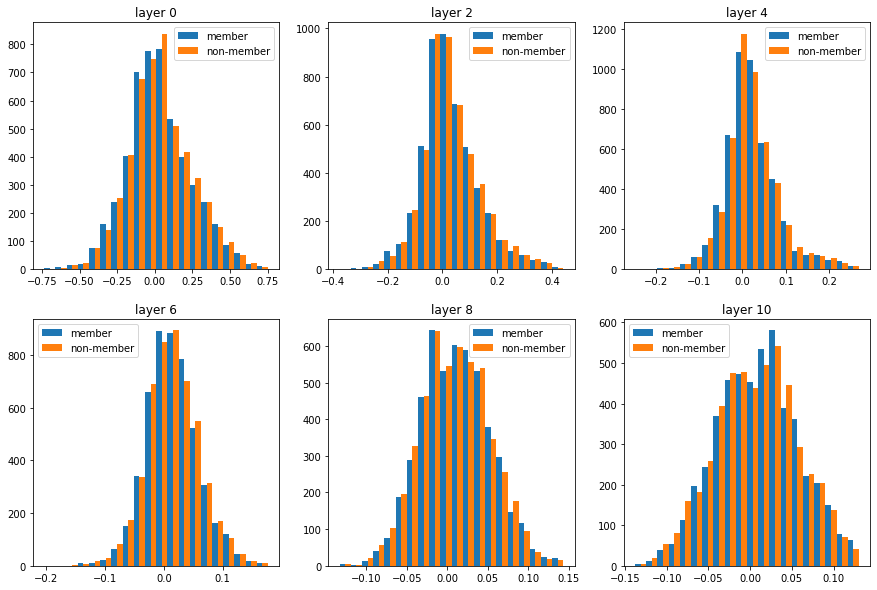

counting and norm combined ACC:0.5140471209114165


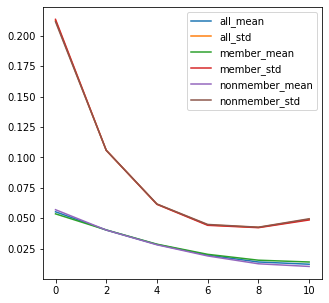

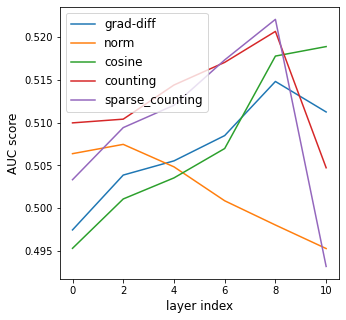

epoch: 20
(10000, 12, 24)


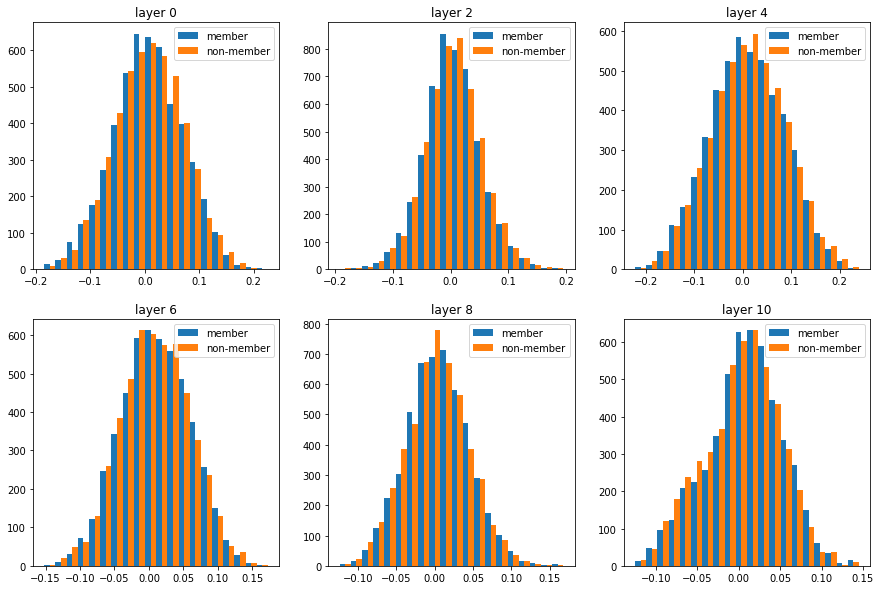

counting and norm combined ACC:0.515


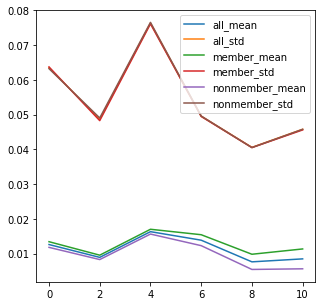

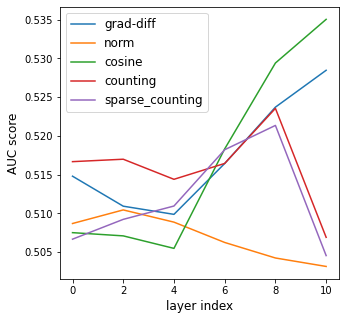

epoch: 30
(10000, 12, 24)


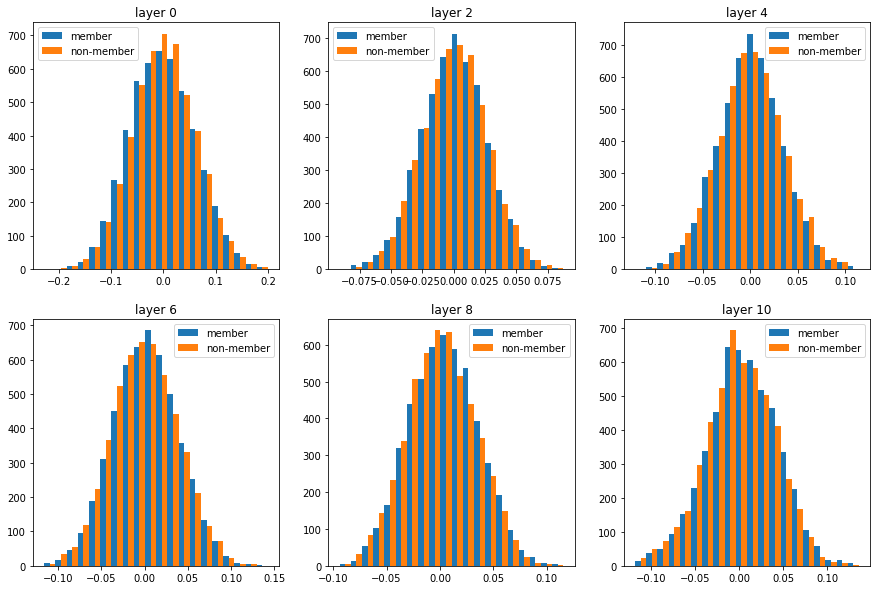

counting and norm combined ACC:0.5095689151826553


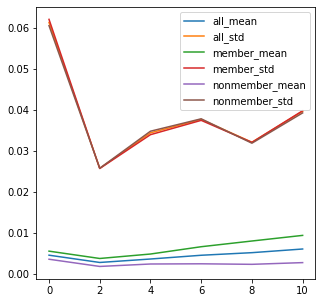

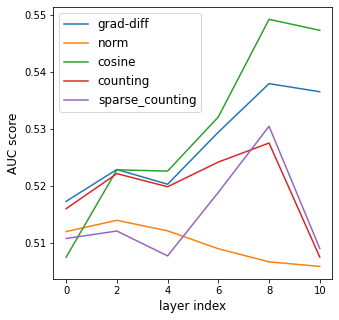

epoch: 40
(10000, 12, 24)


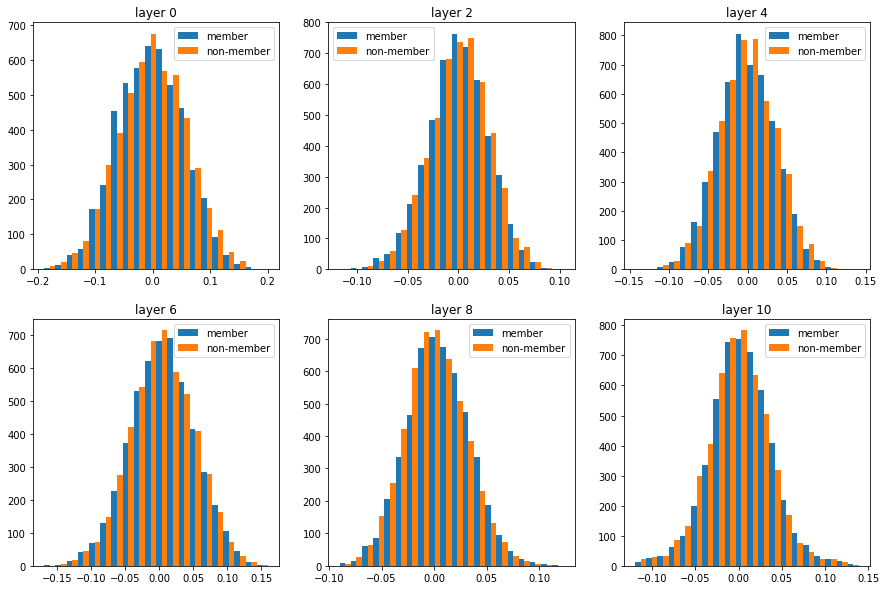

counting and norm combined ACC:0.517005610883591


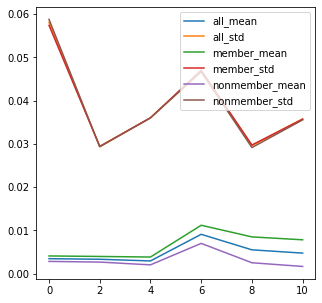

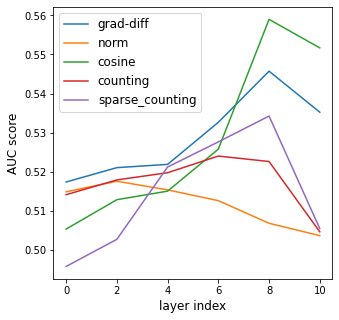

epoch: 50
(10000, 12, 24)


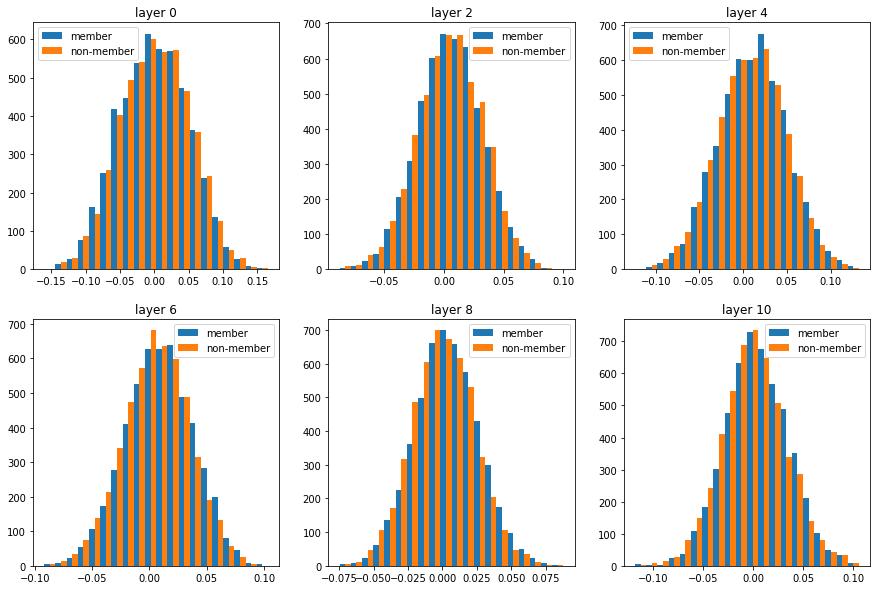

counting and norm combined ACC:0.5181216552676075


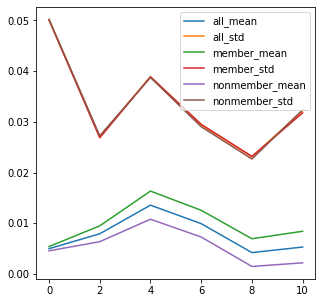

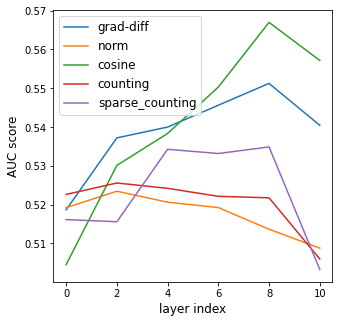

epoch: 60
(10000, 12, 24)


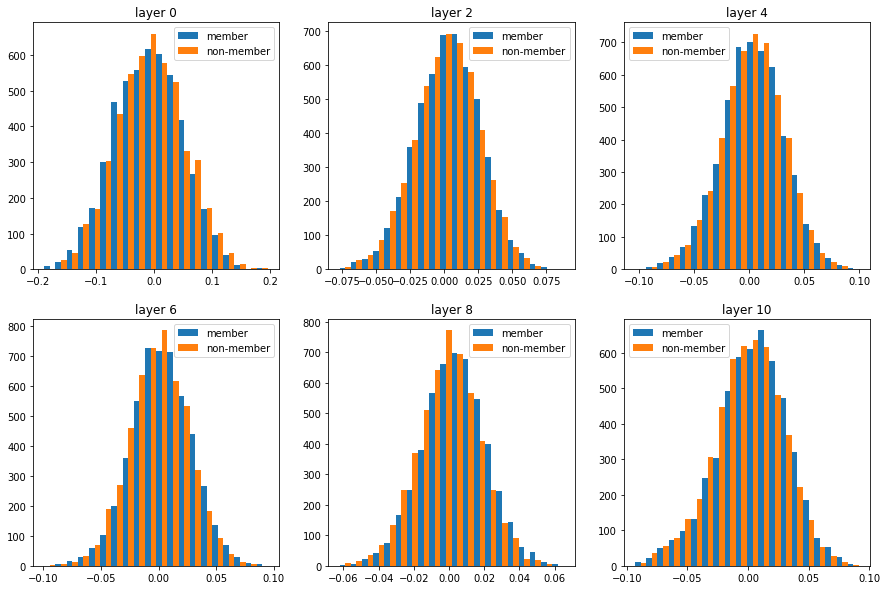

counting and norm combined ACC:0.5302867383512545


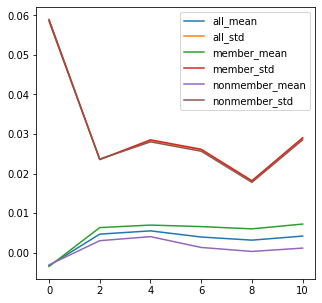

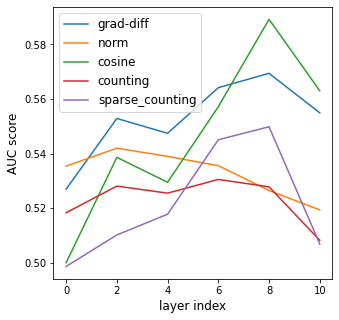

epoch: 70
(10000, 12, 24)


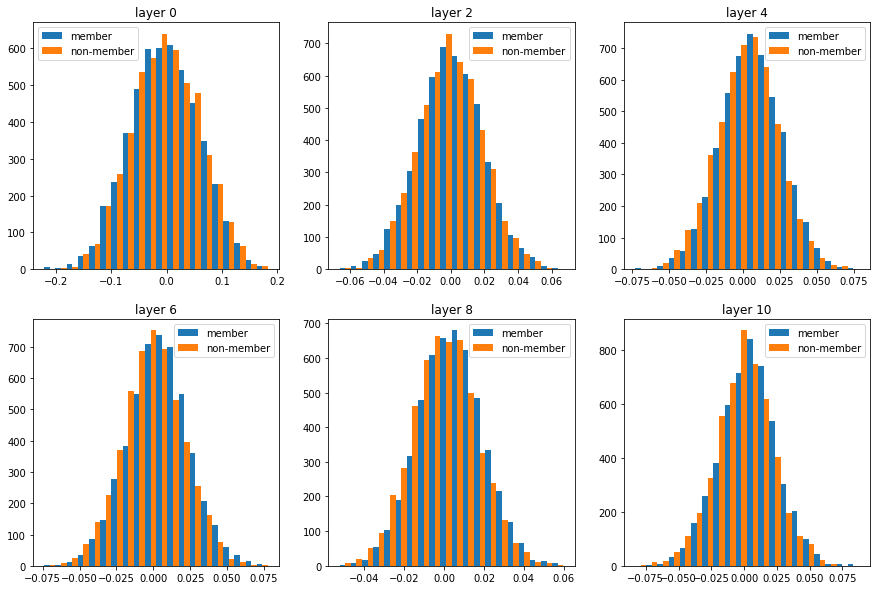

counting and norm combined ACC:0.5407800865248138


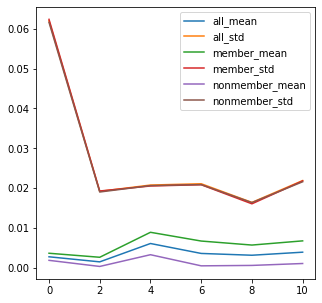

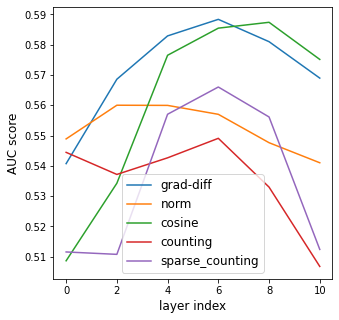

epoch: 80
(10000, 12, 24)


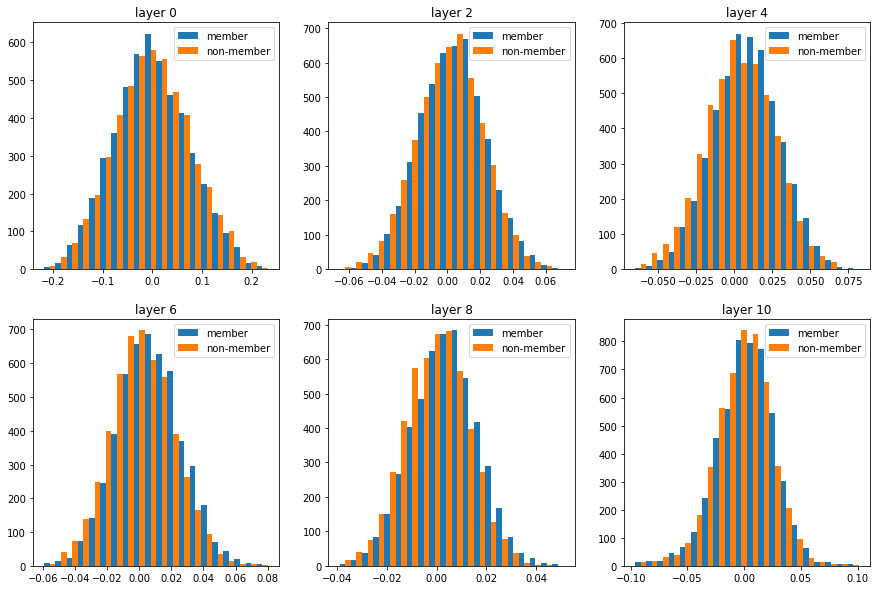

counting and norm combined ACC:0.5566814209489046


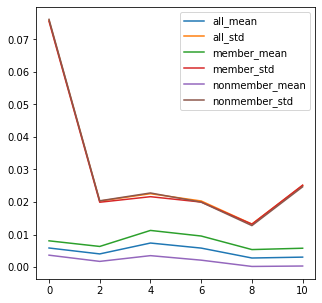

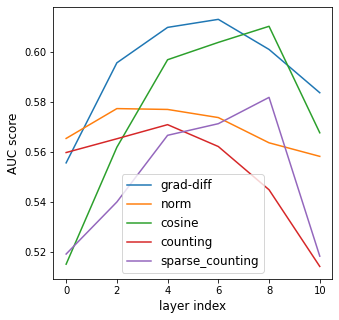

epoch: 90
(10000, 12, 24)


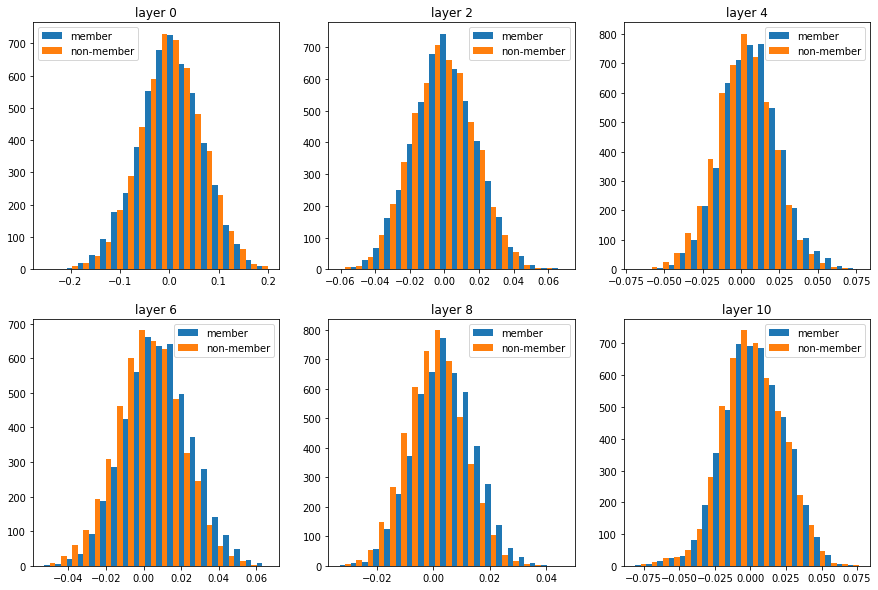

counting and norm combined ACC:0.5803006381648604


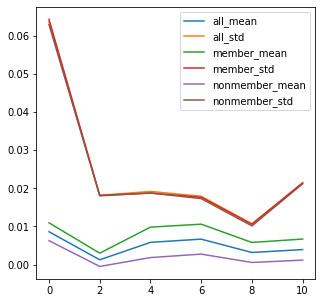

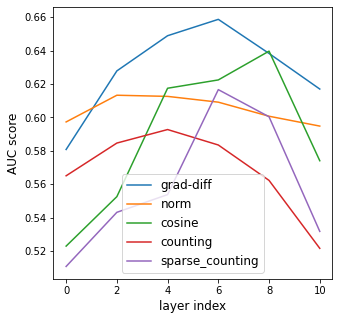

epoch: 100
(10000, 12, 24)


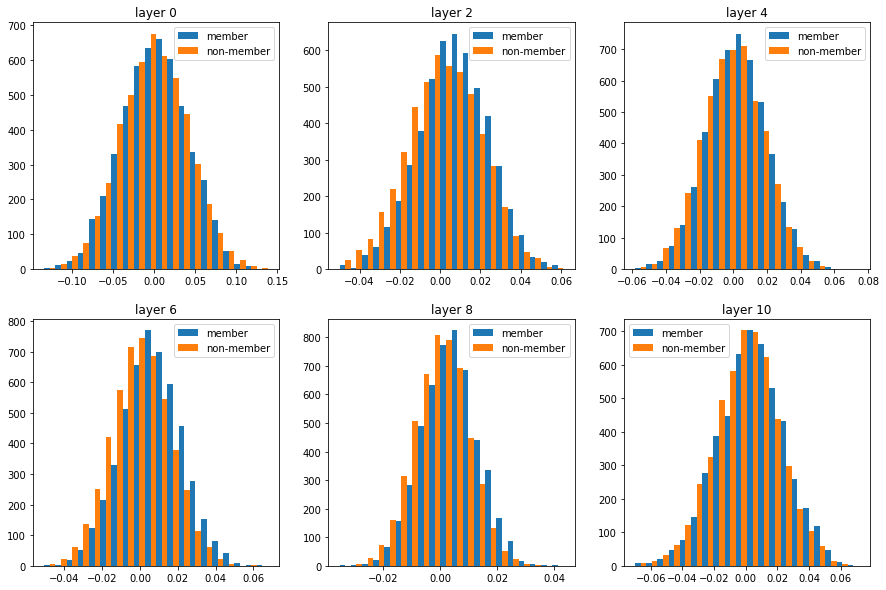

counting and norm combined ACC:0.615724900827441


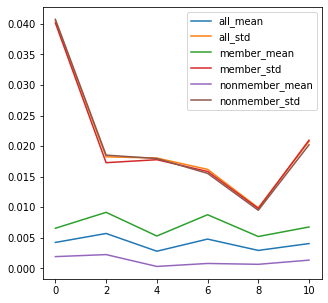

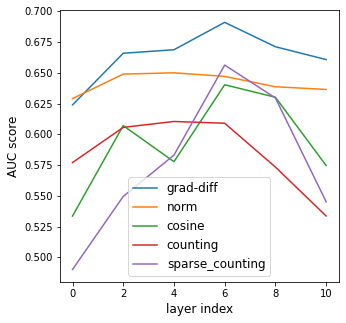

epoch: 110
(10000, 12, 24)


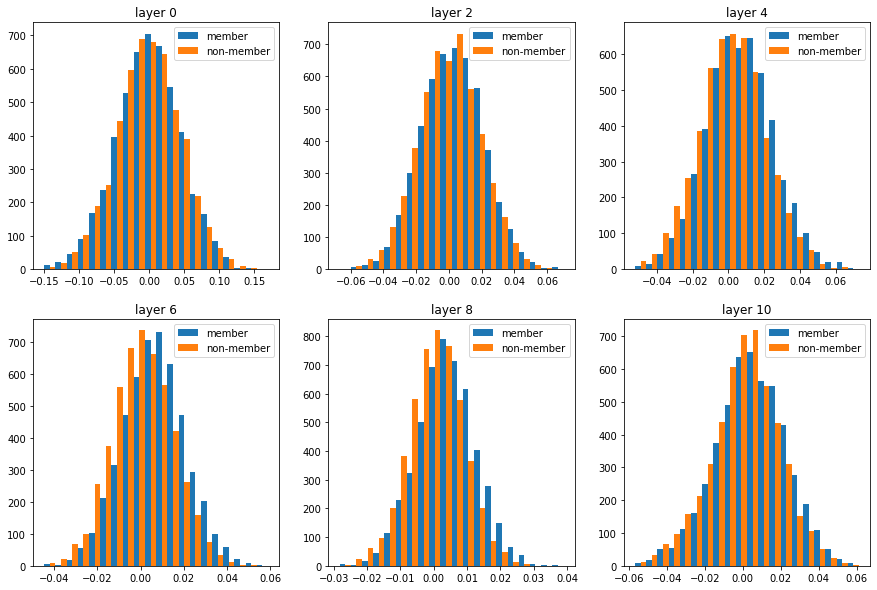

counting and norm combined ACC:0.6457713910803156


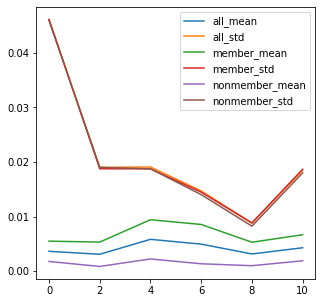

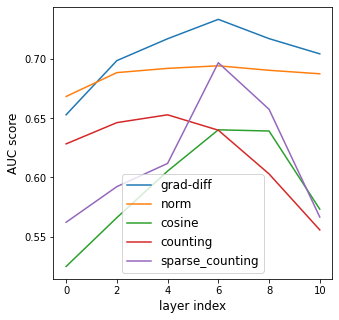

epoch: 120
(10000, 12, 24)


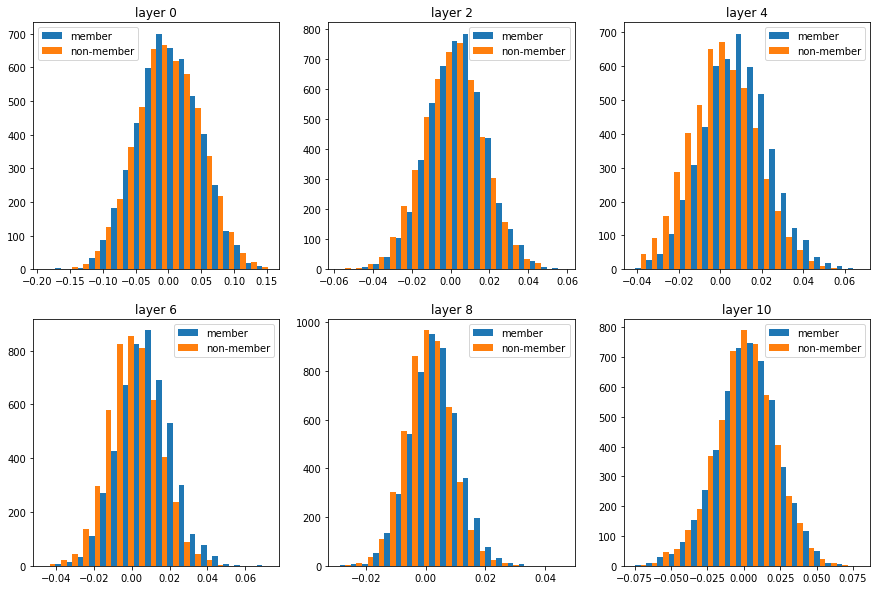

counting and norm combined ACC:0.6898079233056502


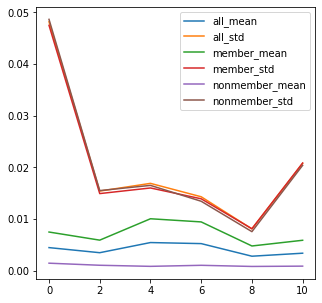

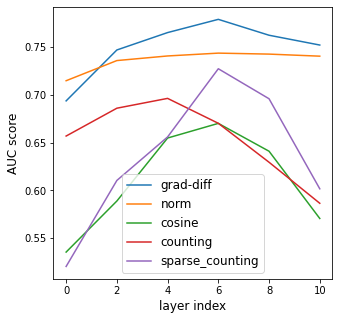

epoch: 130
(10000, 12, 24)


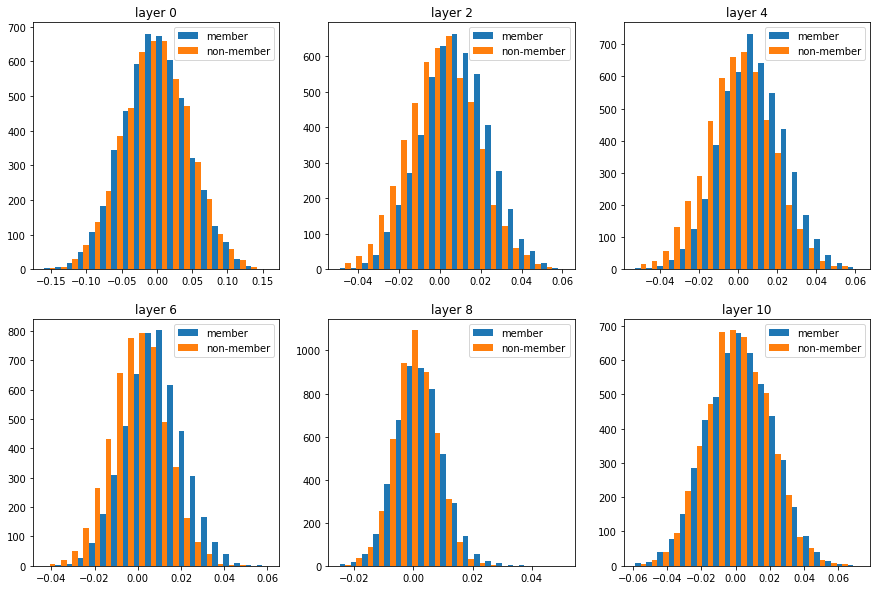

counting and norm combined ACC:0.7316148698715829


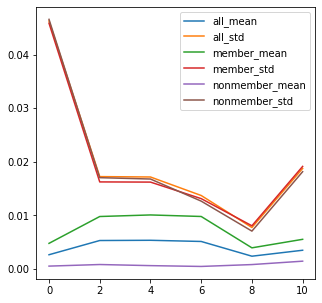

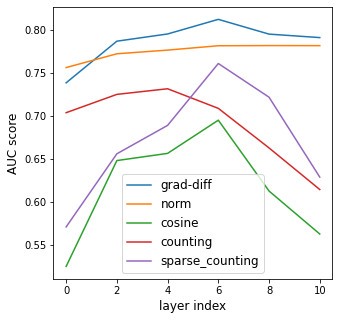

epoch: 140
(10000, 12, 24)


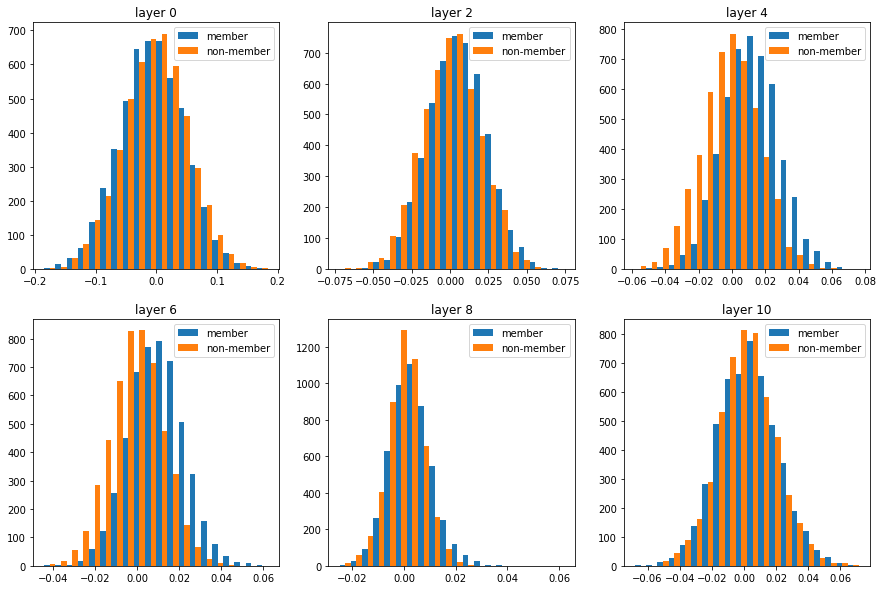

counting and norm combined ACC:0.7750272819758439


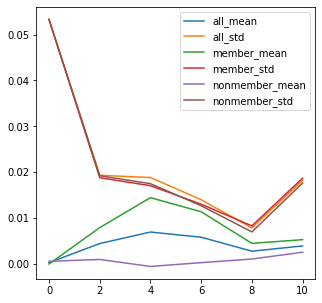

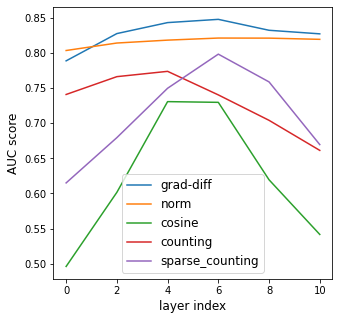

epoch: 150
(10000, 12, 24)


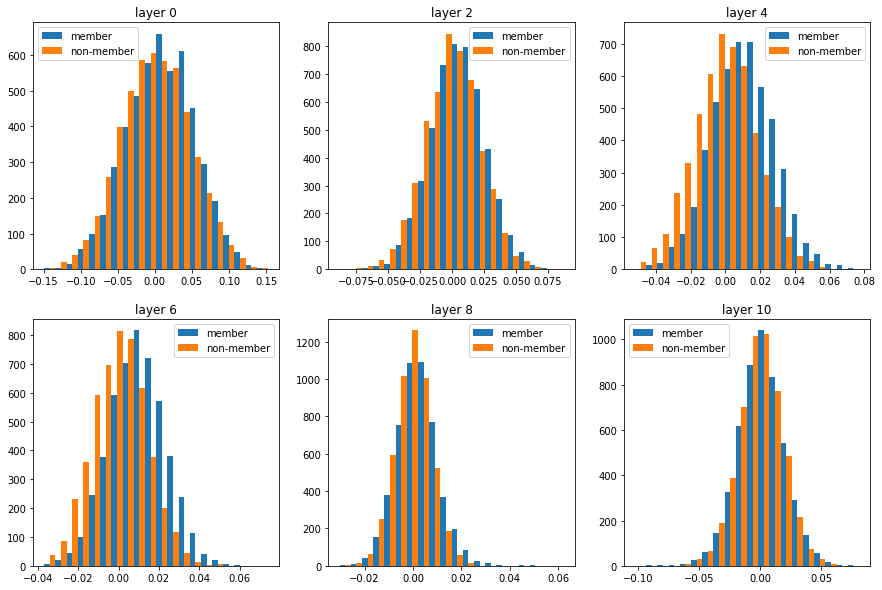

counting and norm combined ACC:0.7872


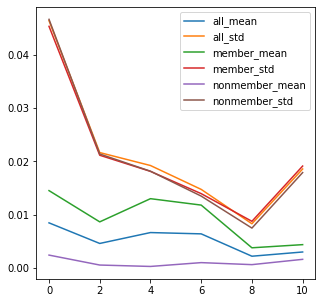

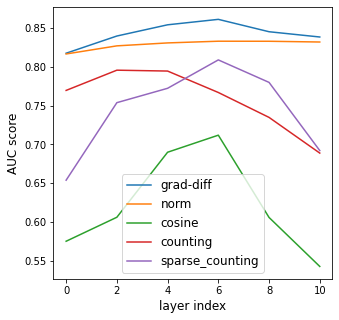

epoch: 160
(10000, 12, 24)


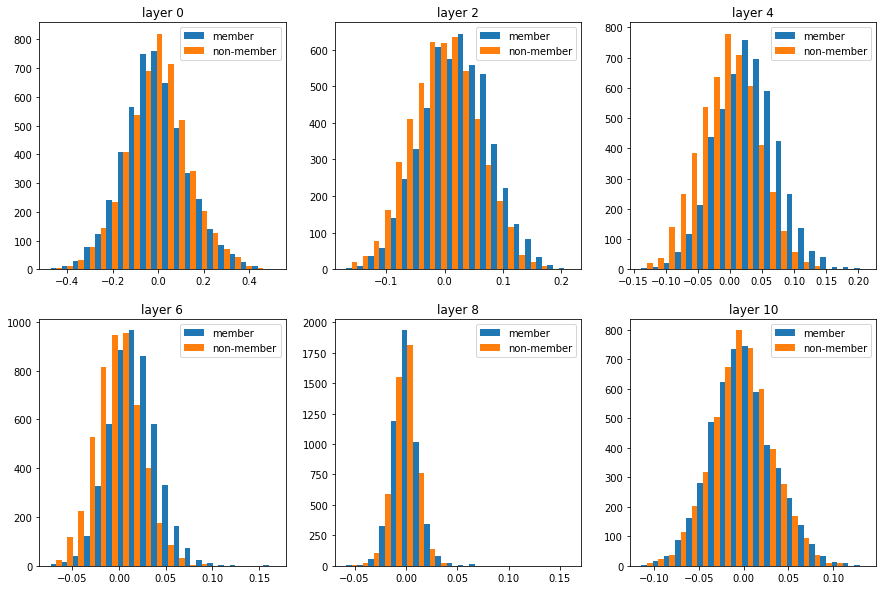

counting and norm combined ACC:0.834673661464094


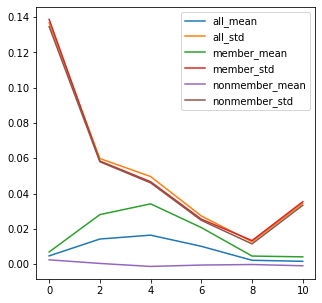

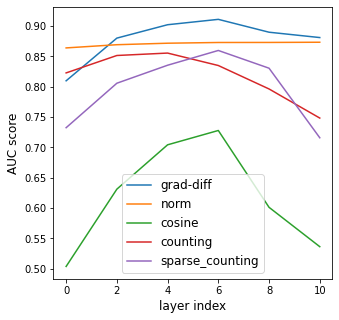

epoch: 170
(10000, 12, 24)


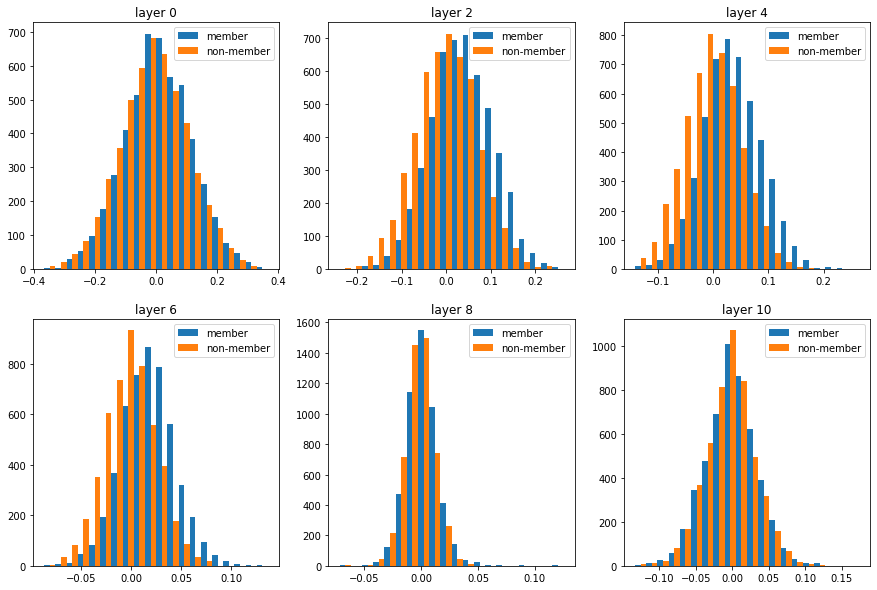

counting and norm combined ACC:0.8454649818599275


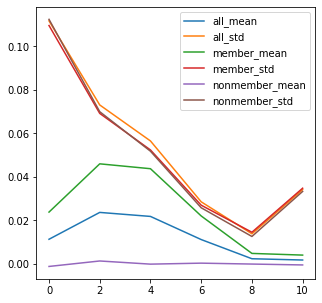

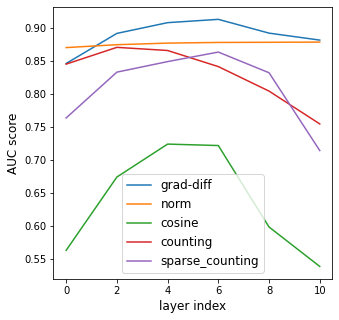

epoch: 180
(10000, 12, 24)


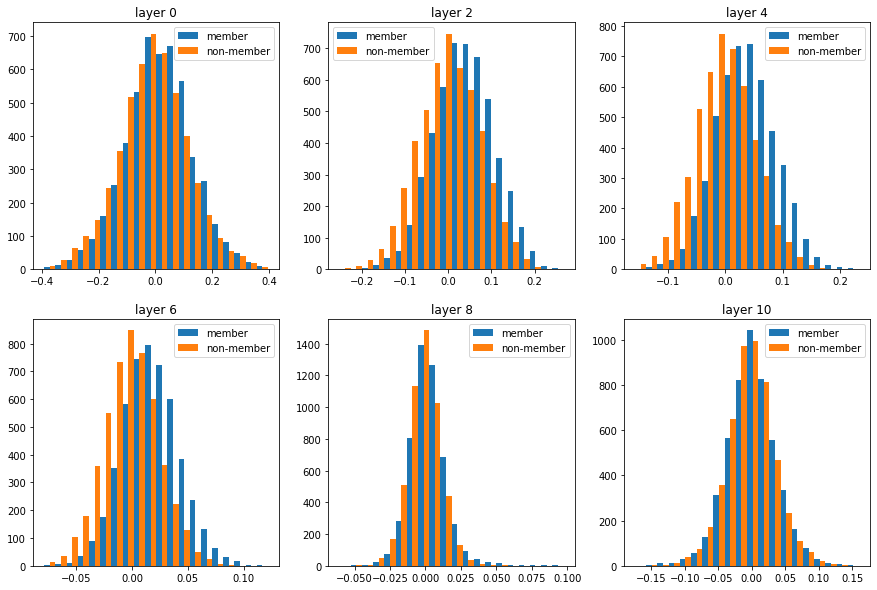

counting and norm combined ACC:0.8430252962608931


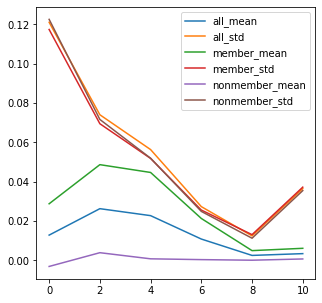

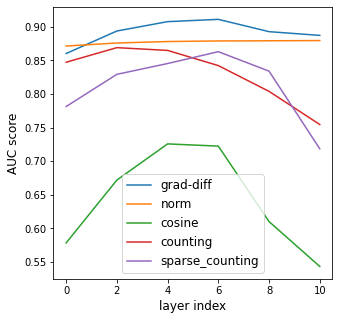

epoch: 190
(10000, 12, 24)


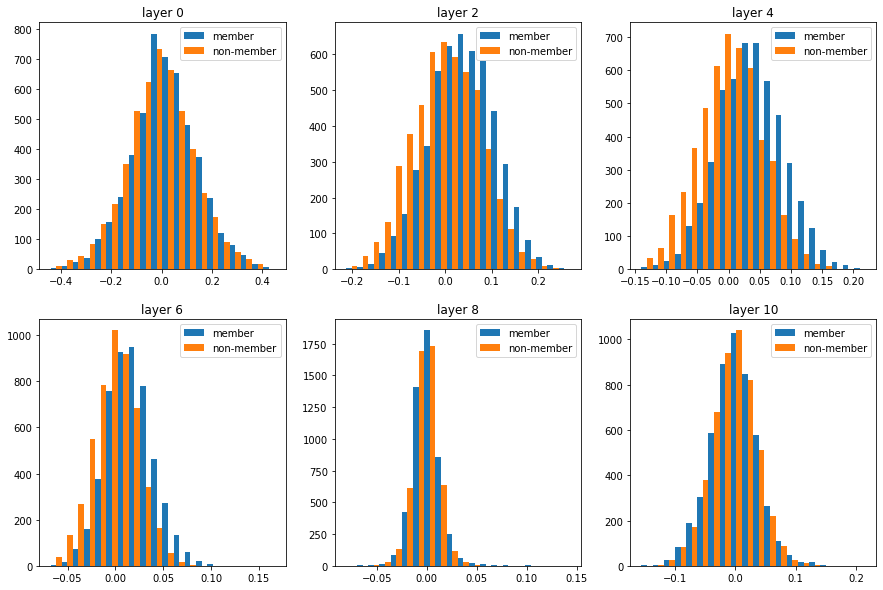

counting and norm combined ACC:0.8420427945191529


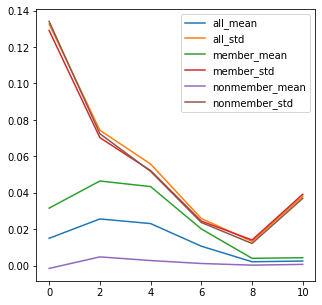

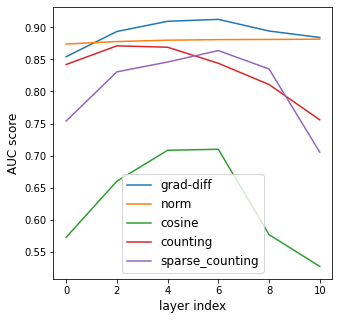

epoch: 200
(10000, 12, 24)


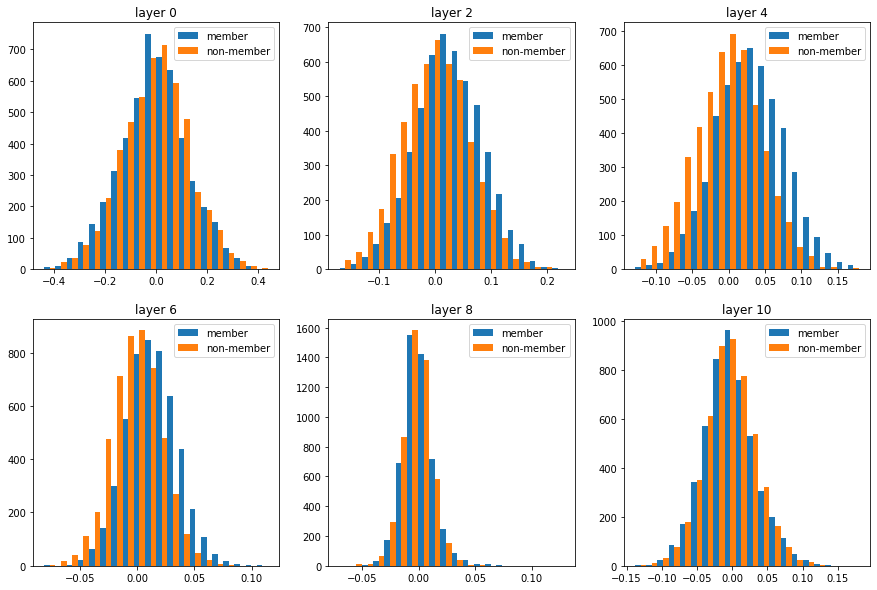

counting and norm combined ACC:0.8528488822057448


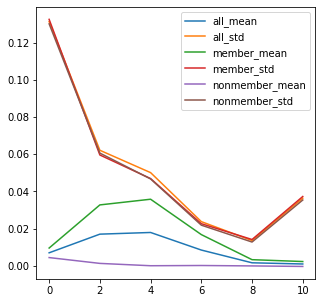

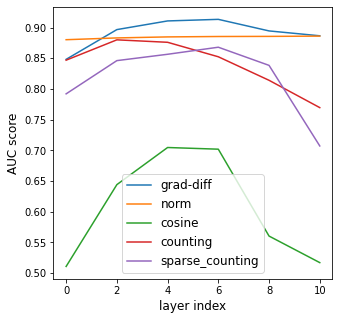

epoch: 210
(10000, 12, 24)


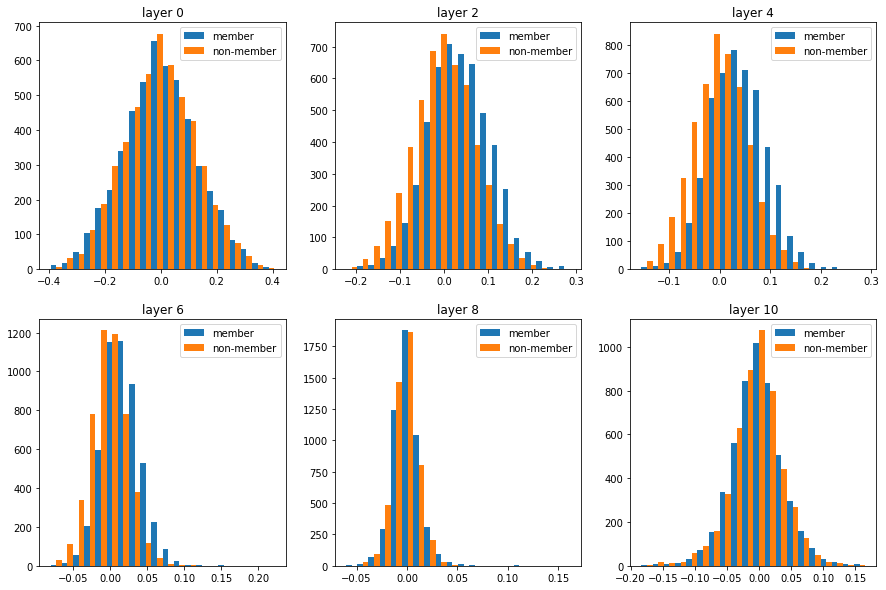

counting and norm combined ACC:0.8524357437536796


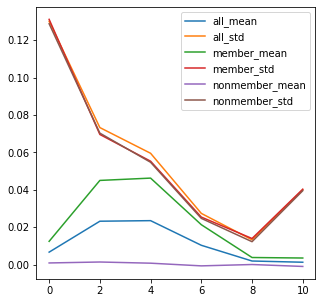

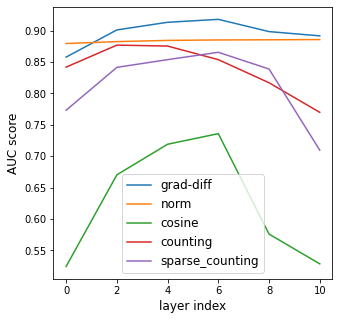

epoch: 220
(10000, 12, 24)


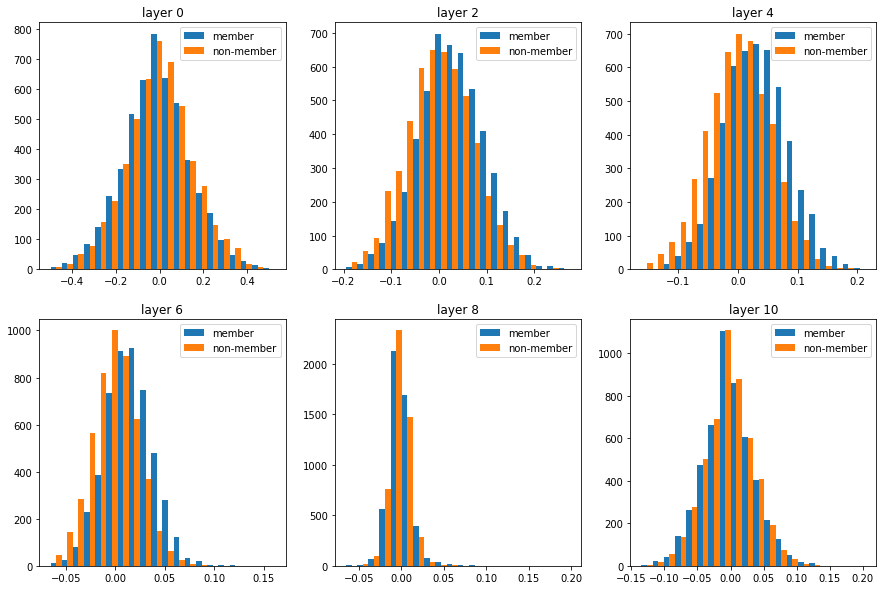

counting and norm combined ACC:0.852275016525166


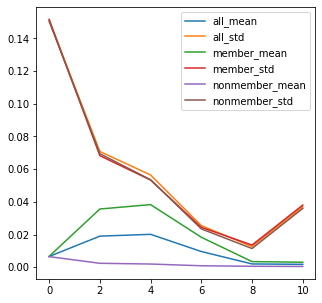

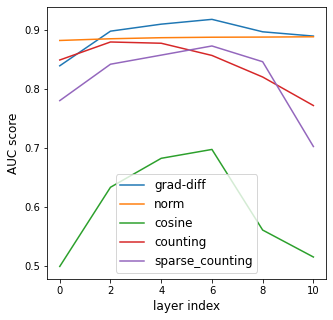

epoch: 230
(10000, 12, 24)


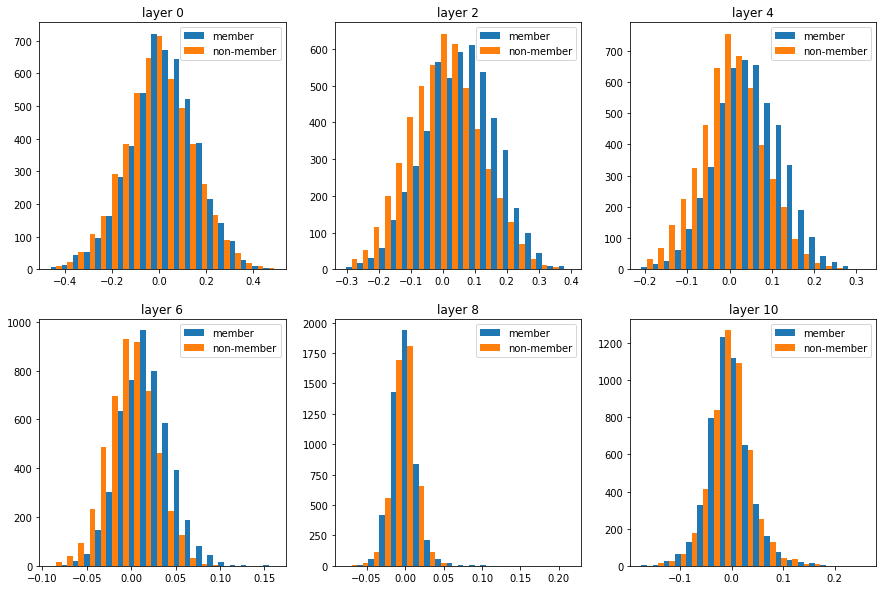

counting and norm combined ACC:0.8527962564969811


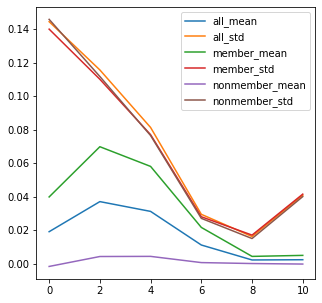

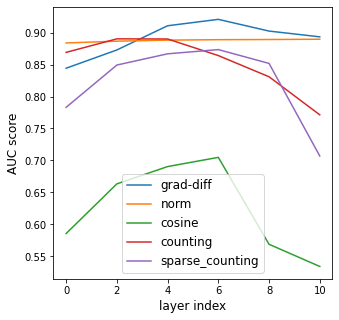

epoch: 240
(10000, 12, 24)


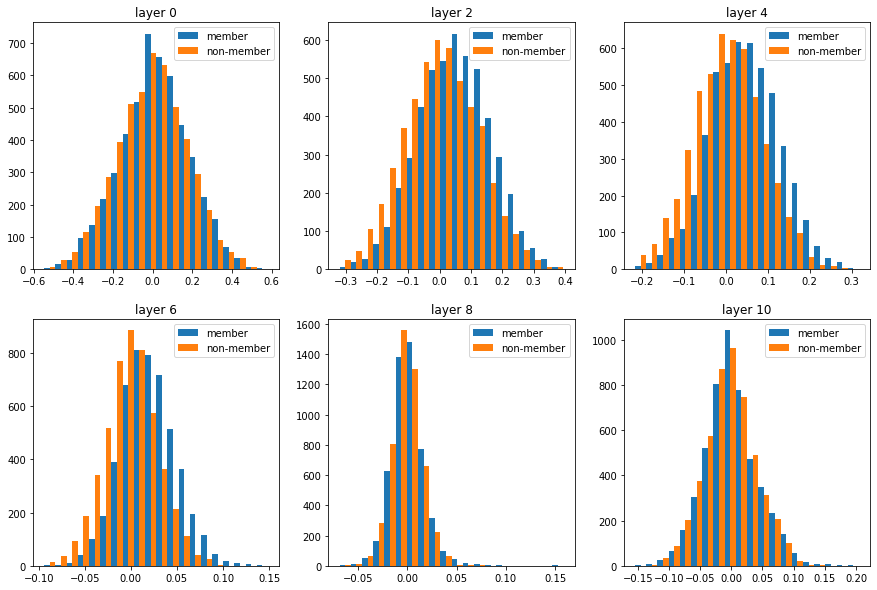

counting and norm combined ACC:0.8537905513343027


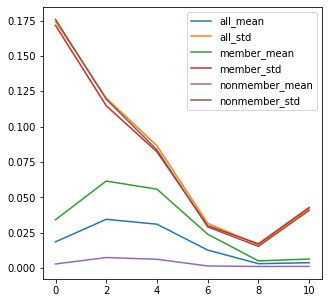

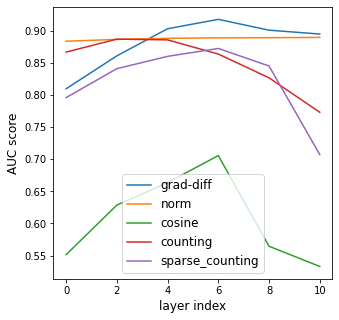

epoch: 250
(10000, 12, 24)


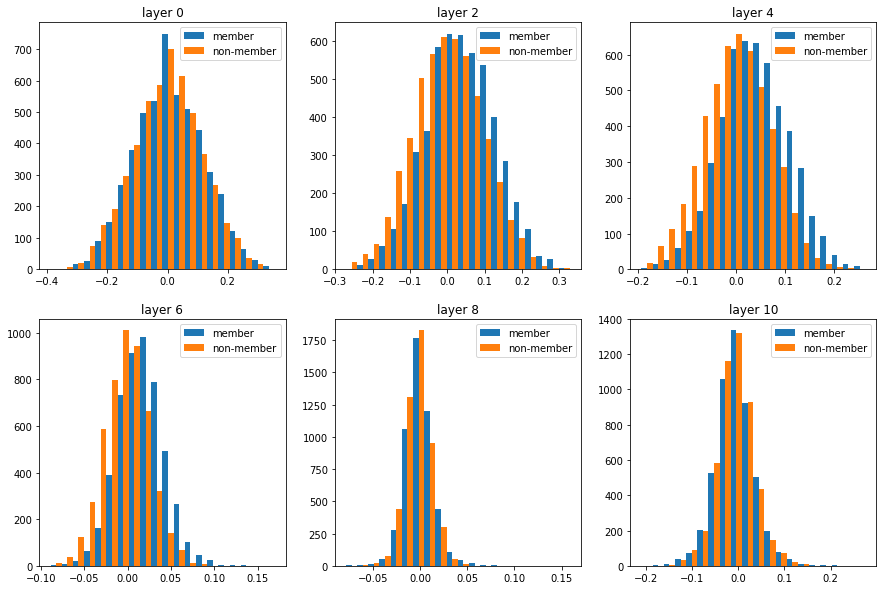

counting and norm combined ACC:0.8540924173528328


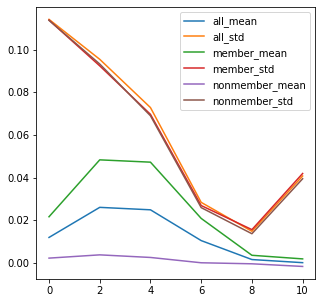

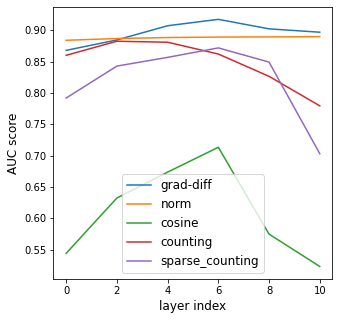

epoch: 260
(10000, 12, 24)


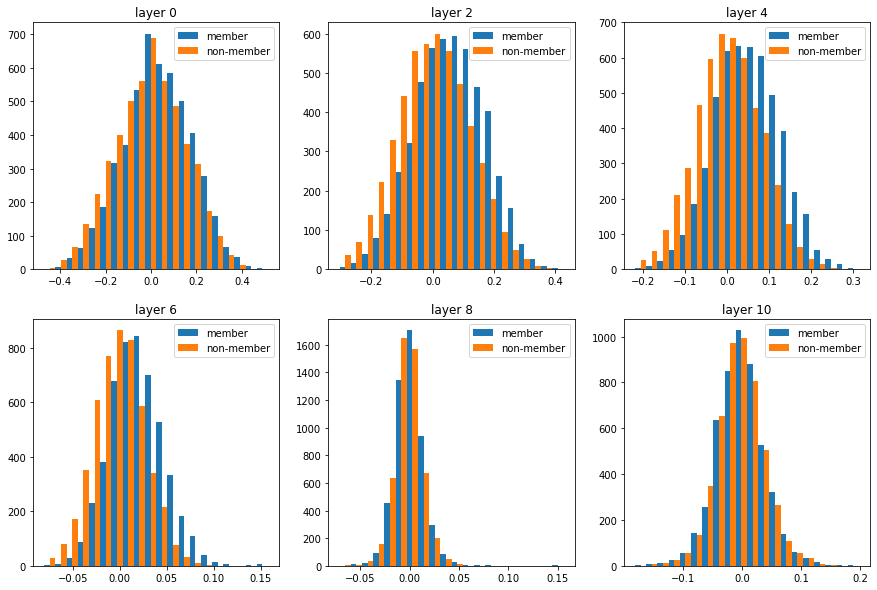

counting and norm combined ACC:0.8615275926526331


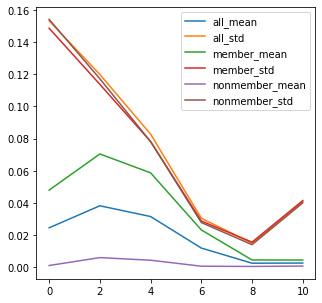

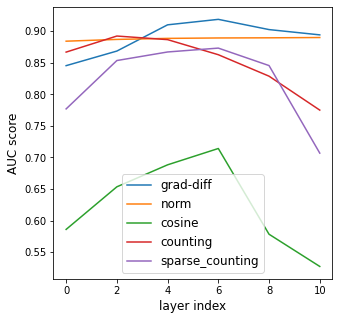

epoch: 270
(10000, 12, 24)


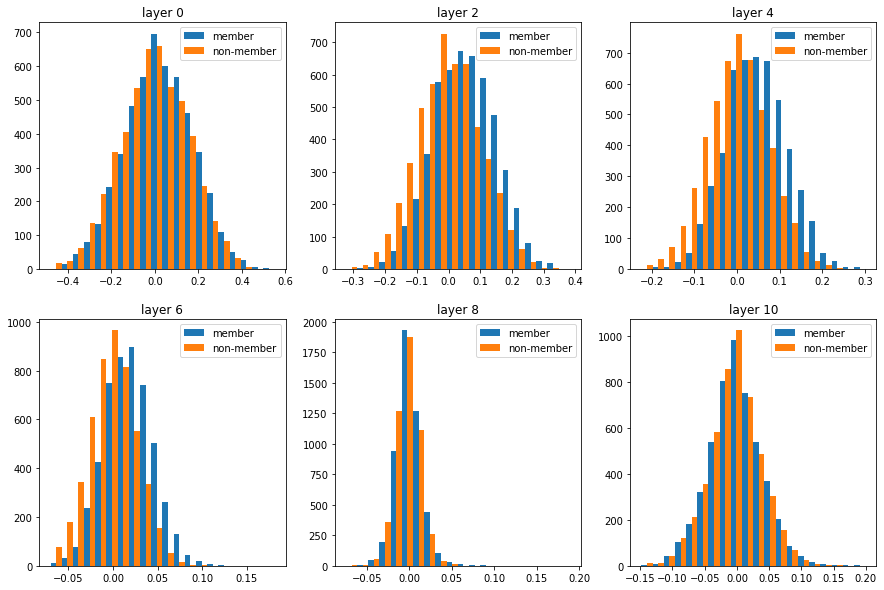

counting and norm combined ACC:0.8531586021505376


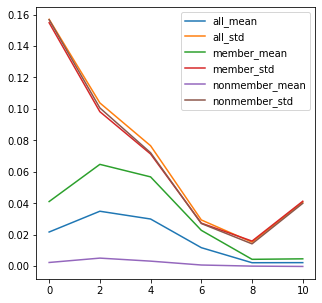

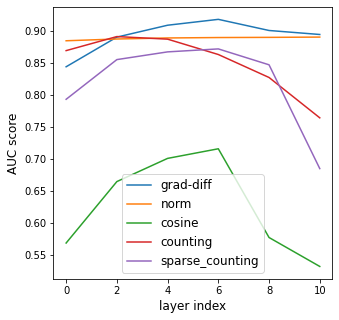

epoch: 280
(10000, 12, 24)


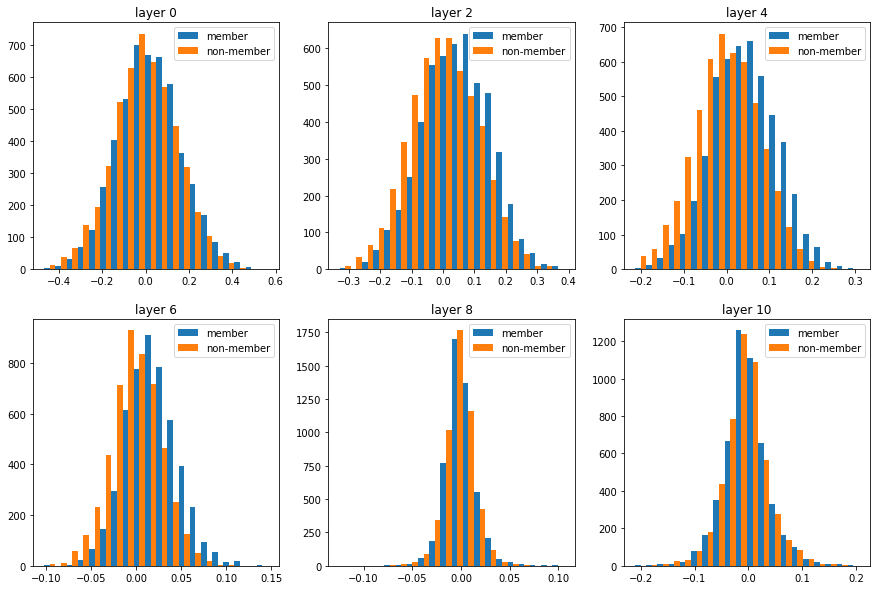

counting and norm combined ACC:0.8537602856781248


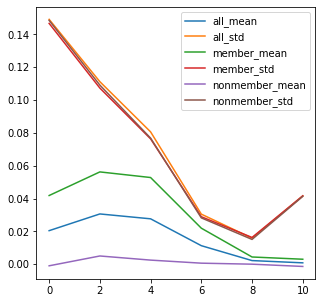

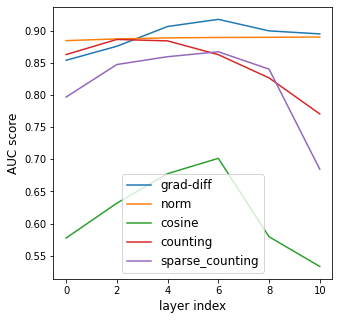

epoch: 290
(10000, 12, 24)


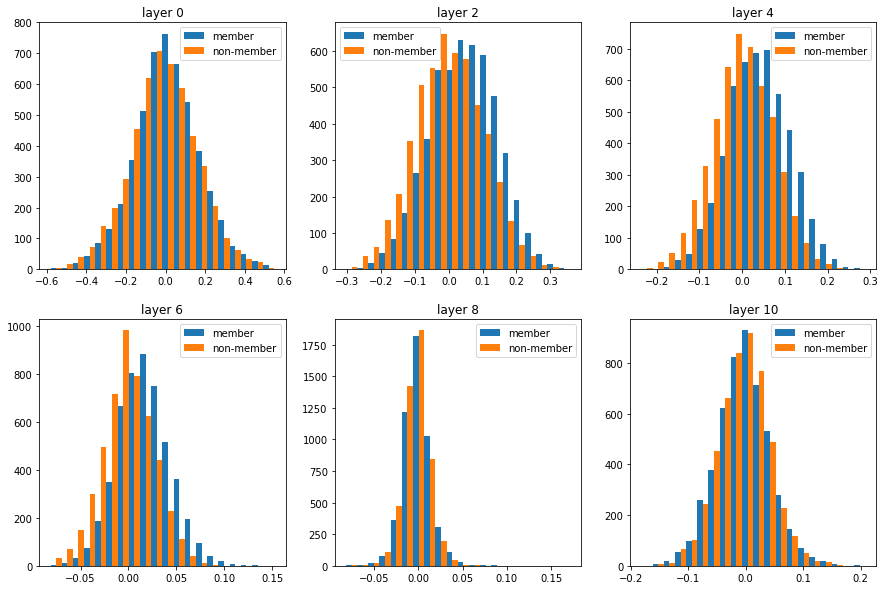

counting and norm combined ACC:0.8553988335565006


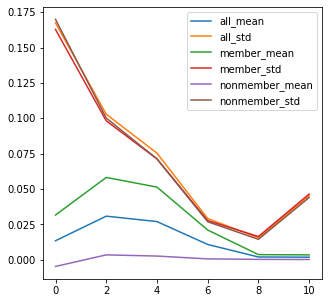

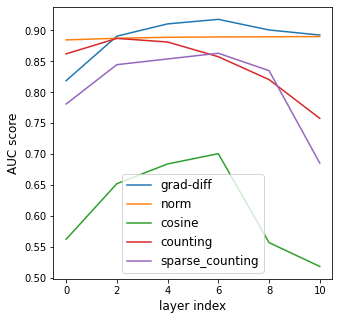

epoch: 300
(10000, 12, 24)


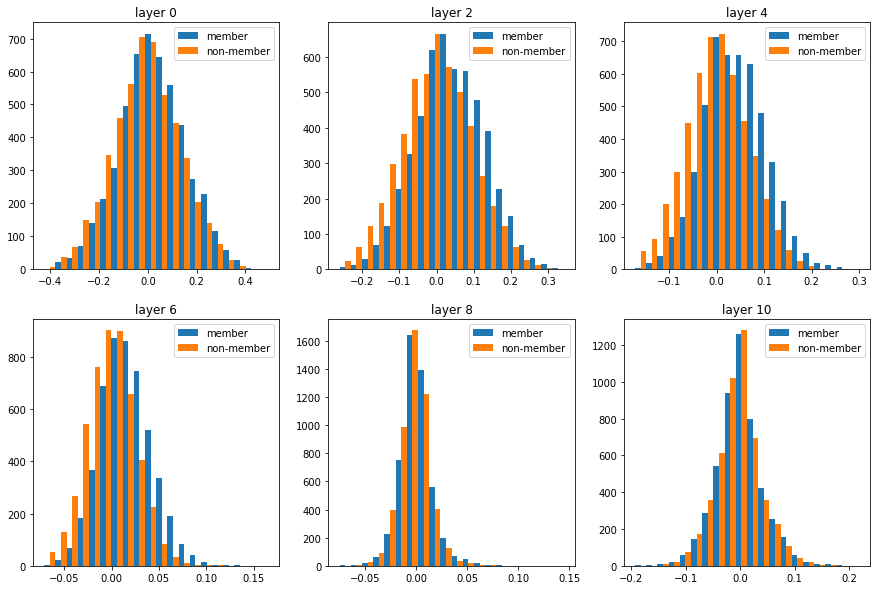

counting and norm combined ACC:0.8543862352509517


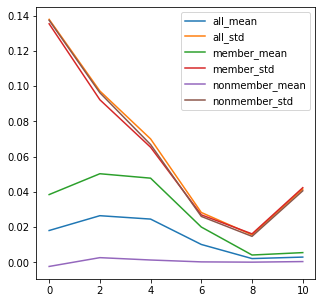

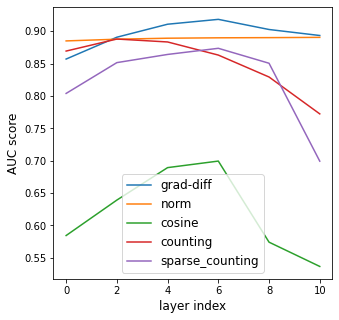

In [2]:
epochs = (np.arange(30)+1)*10
layer_analysis(epochs,5000,12,5000,'alexnet','cifar100',name_prefix='/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_non_member_single_epoch_',
               special_layers=[0,2,4,6,8,10])


user_idx:0
layer cosine AUC score 0.6490248799999999


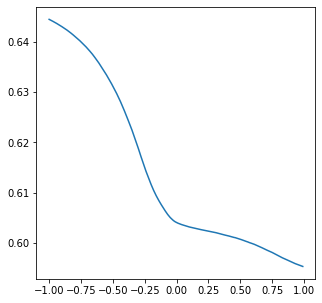

user_idx:1
layer cosine AUC score 0.7011444800000001


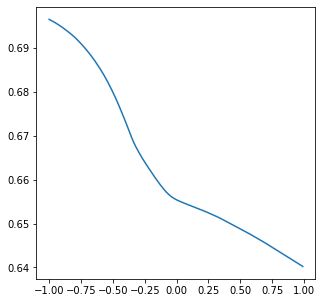

user_idx:2
layer cosine AUC score 0.67207712


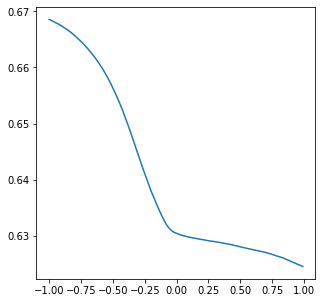

In [28]:
epochs = (np.arange(30)+1)*10
weighted_cosine(epochs[-10:],5000,12,5000,'alexnet','cifar100',name_prefix='/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_non_member_single_epoch_',
               special_layers=[0,2,4,6,8,10])


epoch: 210
(10000, 12, 24)


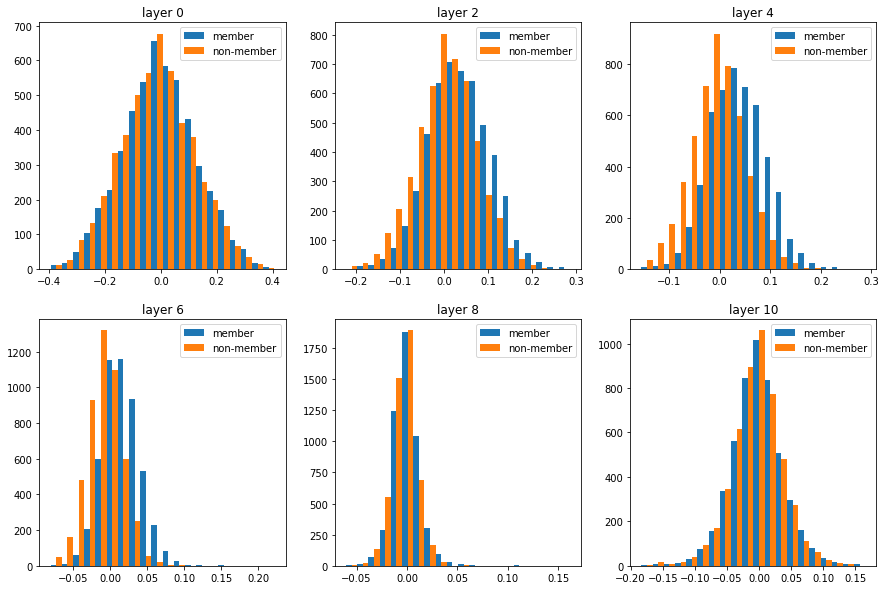

counting and norm combined ACC:0.5183838383838384


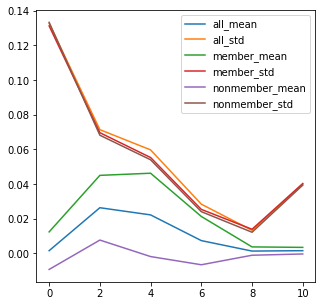

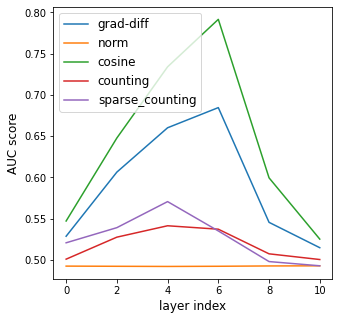

epoch: 220
(10000, 12, 24)


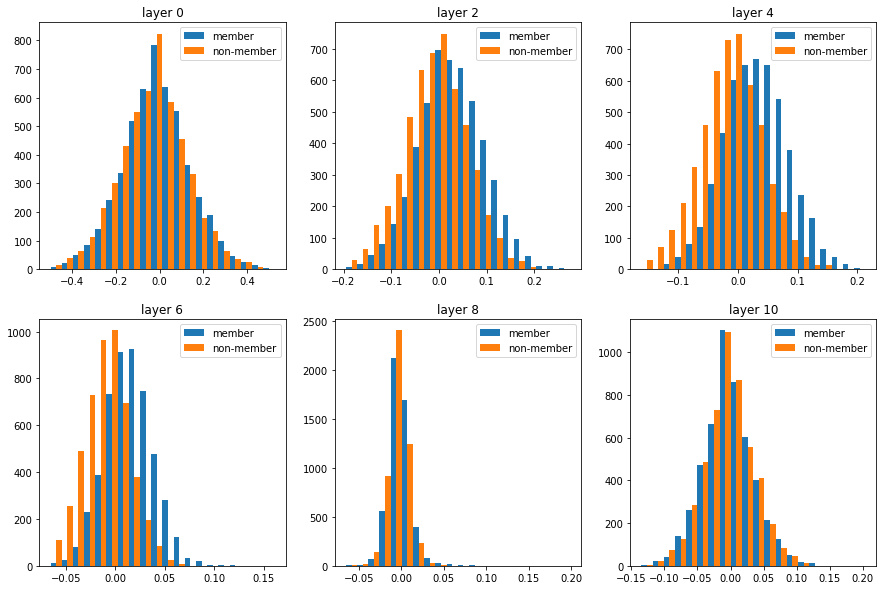

counting and norm combined ACC:0.5171480889569315


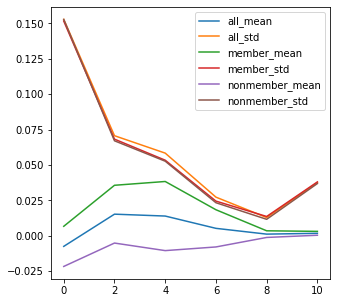

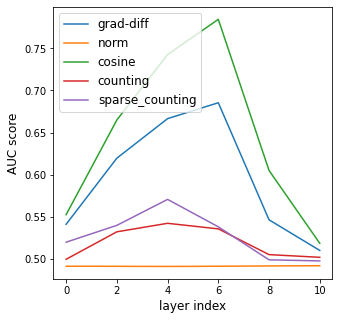

epoch: 230
(10000, 12, 24)


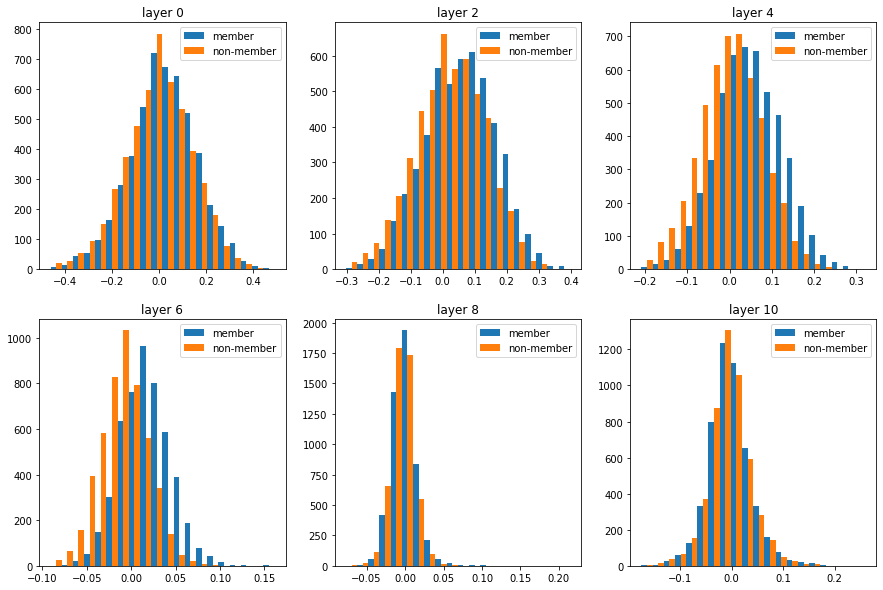

counting and norm combined ACC:0.5180572829886654


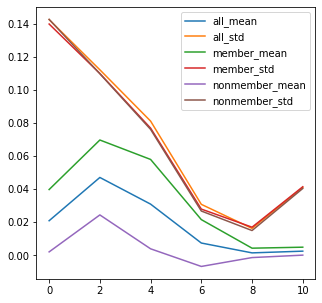

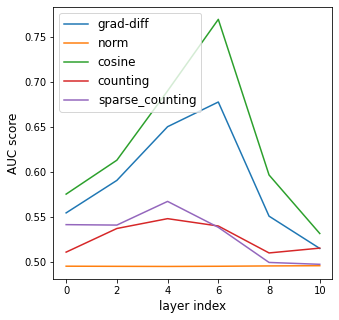

epoch: 240
(10000, 12, 24)


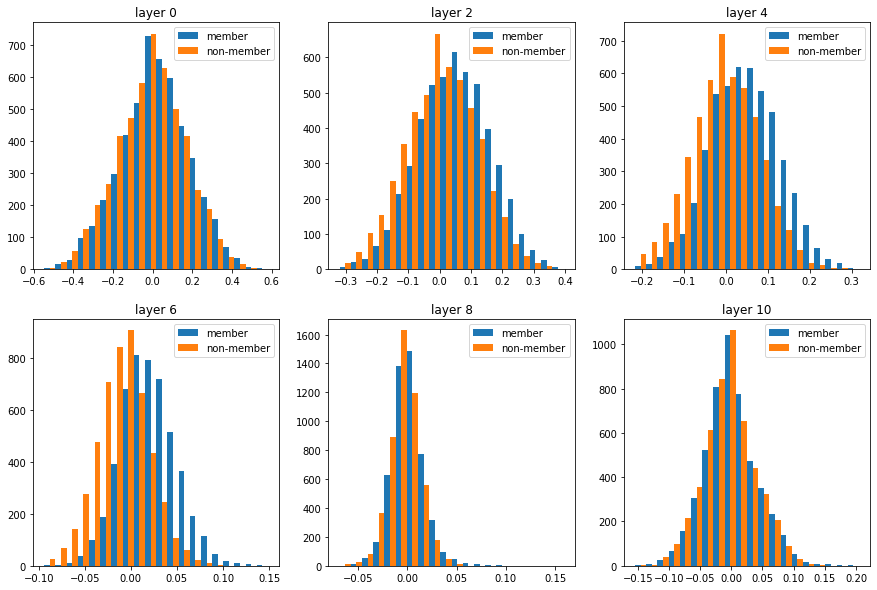

counting and norm combined ACC:0.5183047345359822


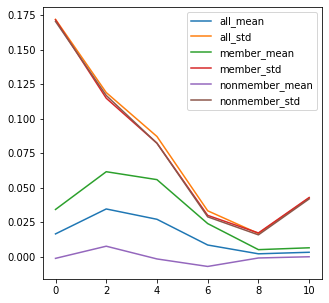

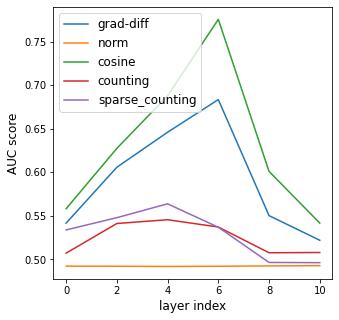

epoch: 250
(10000, 12, 24)


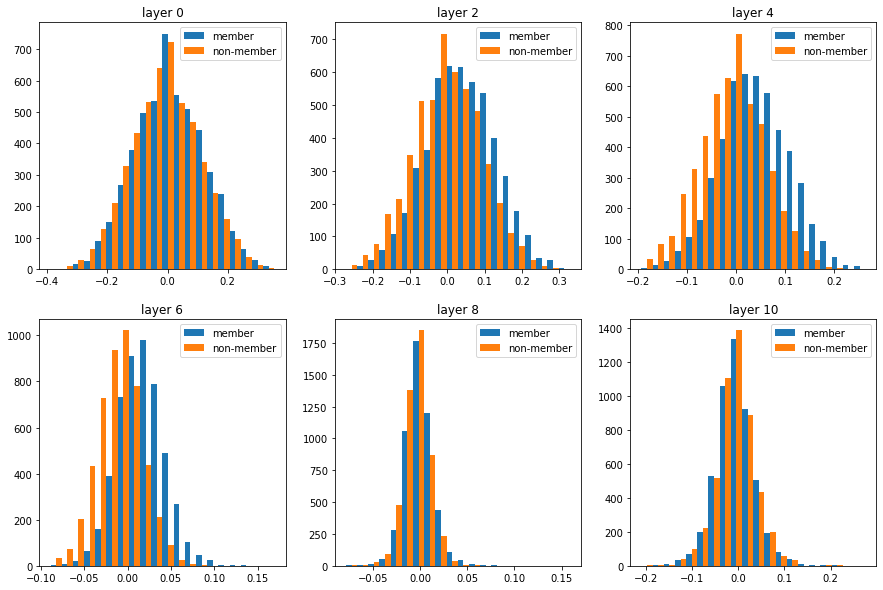

counting and norm combined ACC:0.5117282701869776


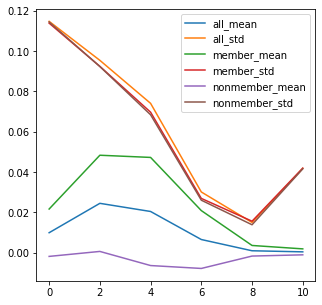

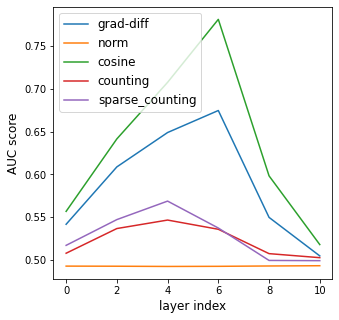

epoch: 260
(10000, 12, 24)


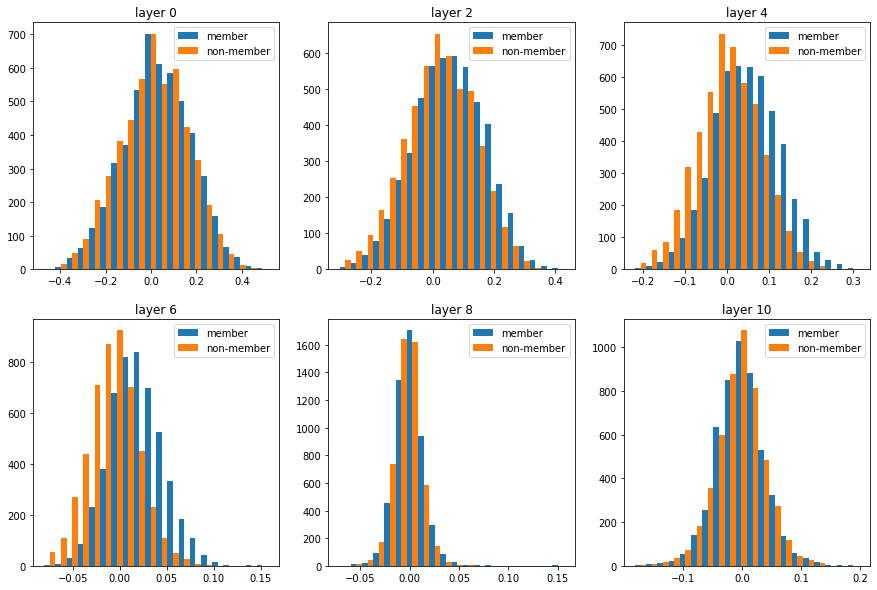

counting and norm combined ACC:0.5125961400598091


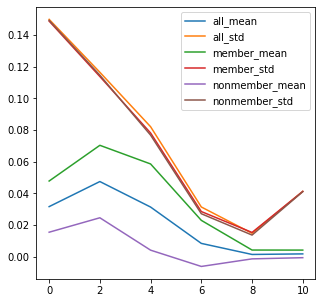

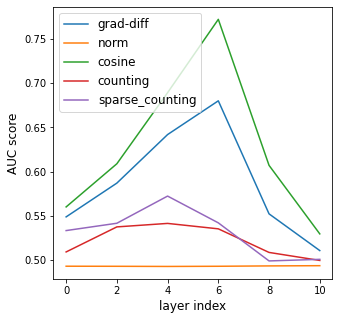

epoch: 270
(10000, 12, 24)


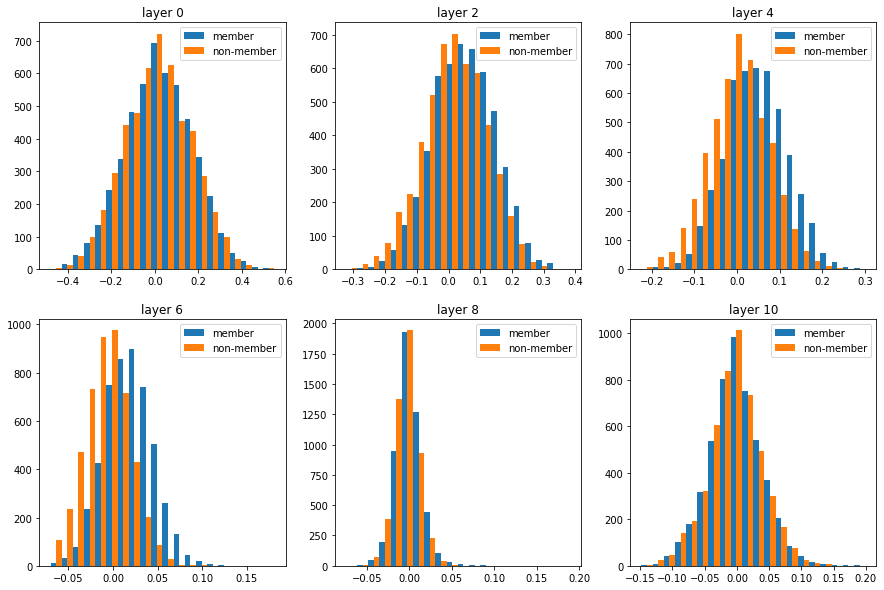

counting and norm combined ACC:0.5151879172541006


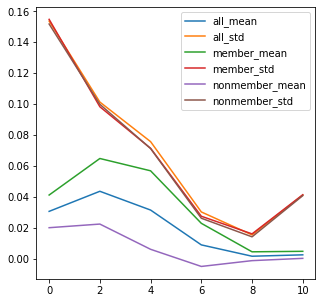

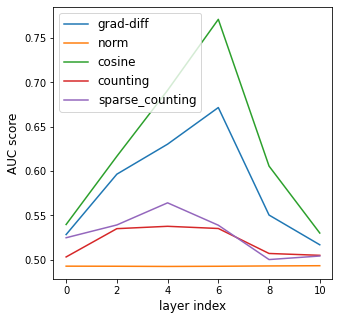

epoch: 280
(10000, 12, 24)


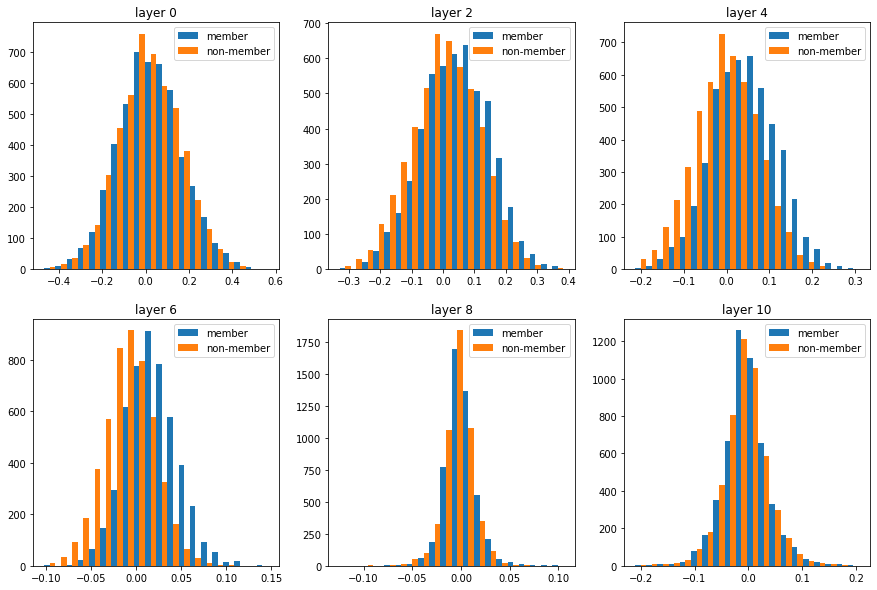

counting and norm combined ACC:0.5174116011632908


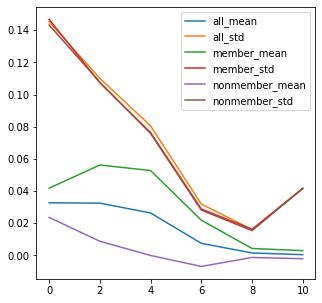

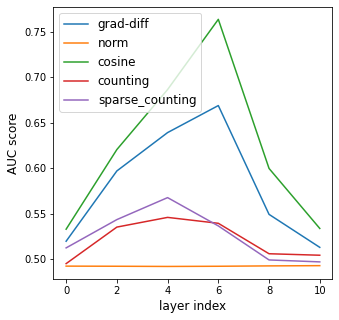

epoch: 290
(10000, 12, 24)


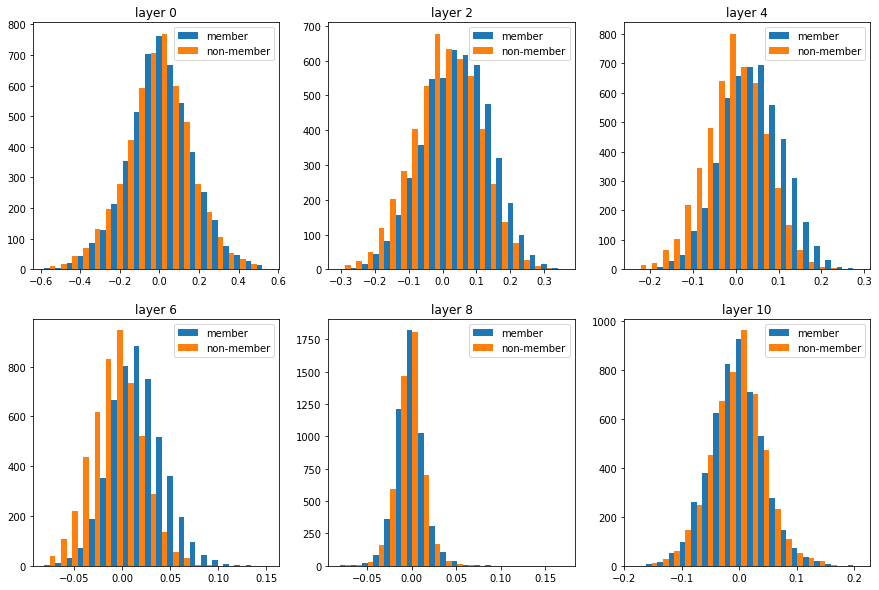

counting and norm combined ACC:0.5160593644478919


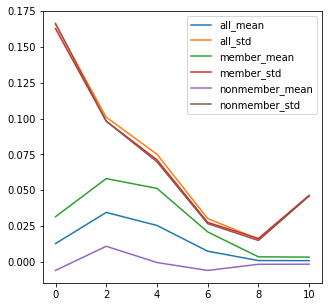

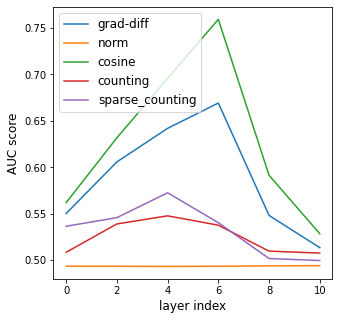

epoch: 300
(10000, 12, 24)


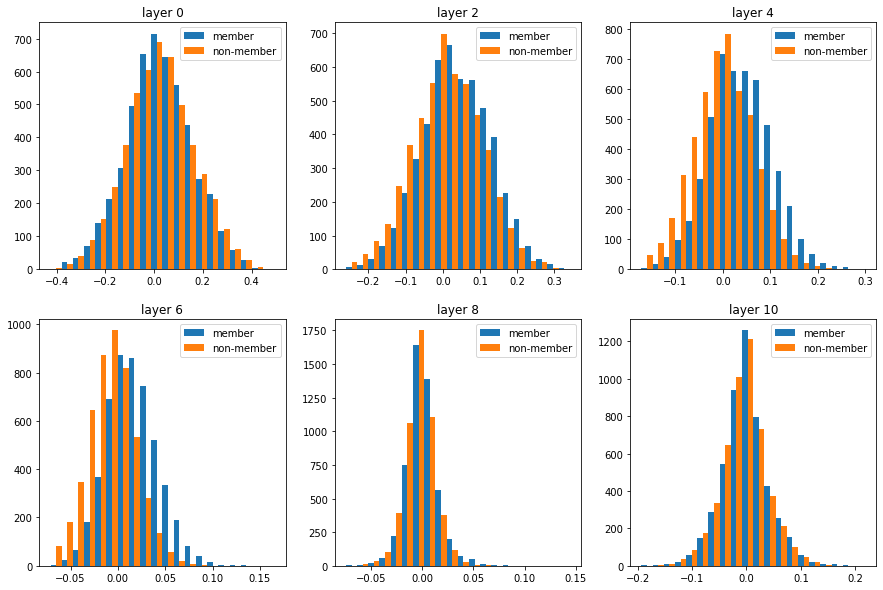

counting and norm combined ACC:0.5115531553155316


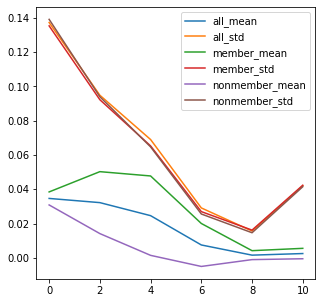

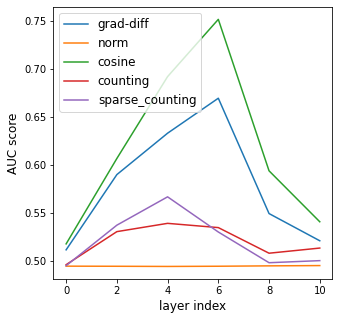

In [4]:
epochs = (np.arange(30)+1)*10
layer_analysis(epochs[-10:],5000,12,5000,'alexnet','cifar100',name_prefix='/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_cross_member_single_epoch_',
               special_layers=[0,2,4,6,8,10])

user_idx:0
layer cosine AUC score 0.78610828


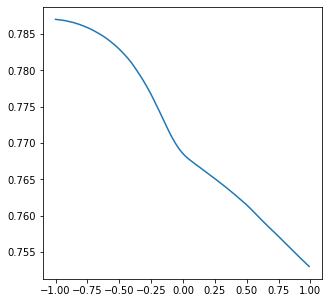

user_idx:1
layer cosine AUC score 0.74540552


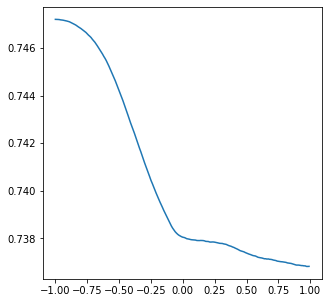

user_idx:2
layer cosine AUC score 0.7913444399999999


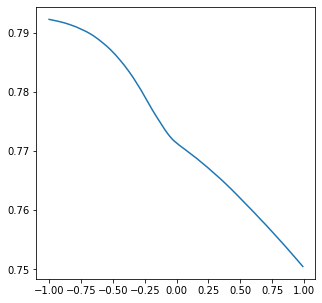

In [29]:
epochs = (np.arange(30)+1)*10
weighted_cosine(epochs,5000,12,5000,'alexnet','cifar100',name_prefix='/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_cross_member_single_epoch_',
               special_layers=[0,2,4,6,8,10])

epoch: 210
(10000, 12, 24)


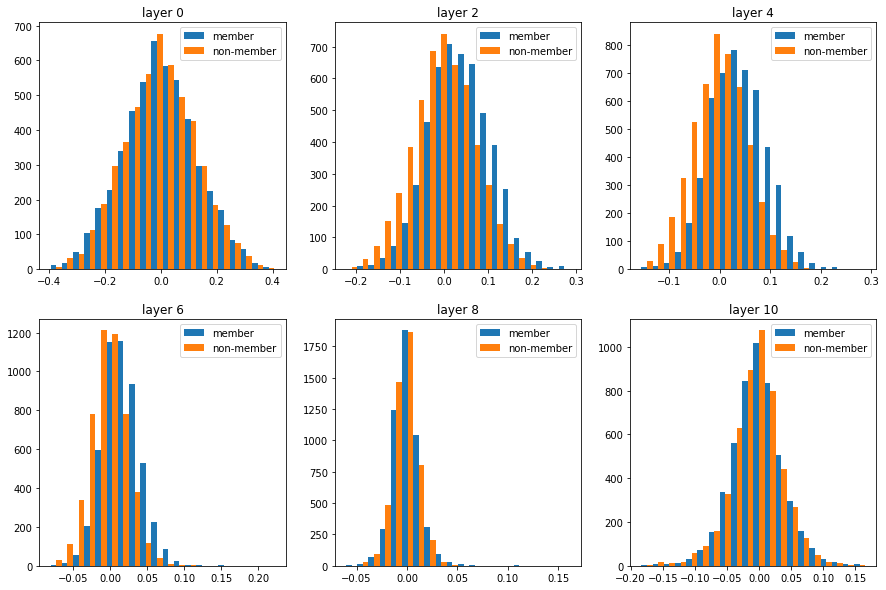

counting and norm combined ACC:0.8474067615246643


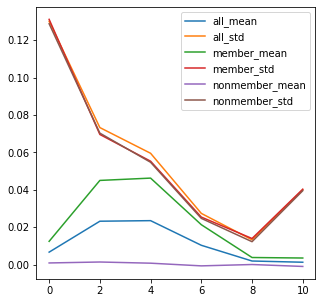

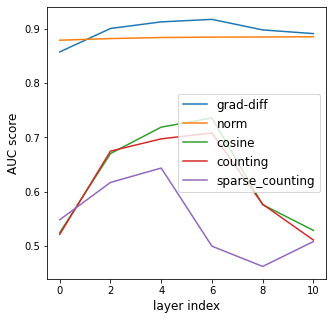

epoch: 220
(10000, 12, 24)


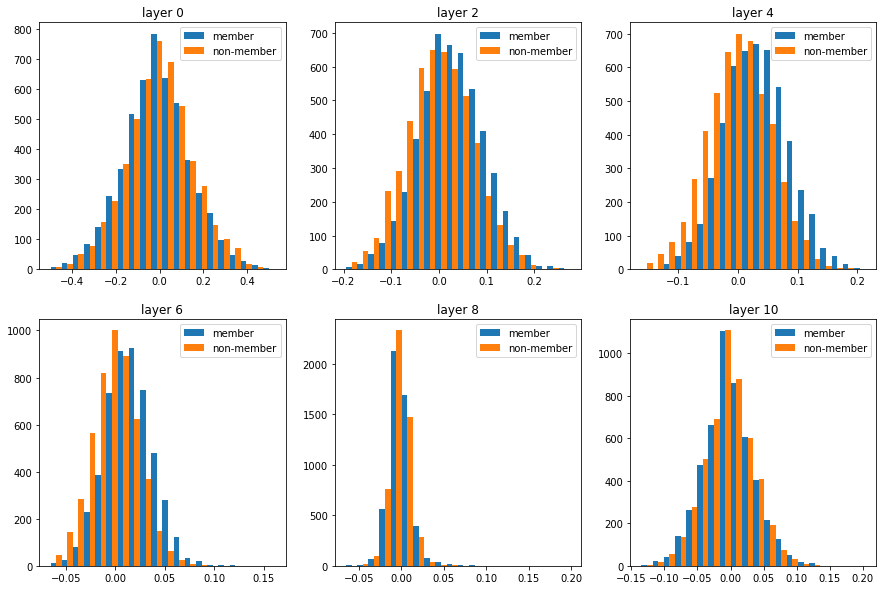

counting and norm combined ACC:0.8527788924638877


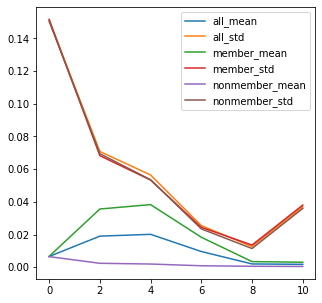

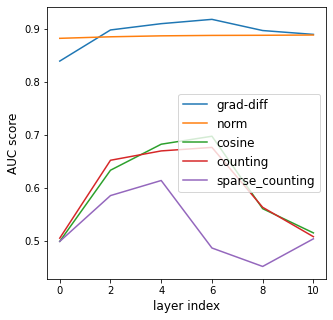

epoch: 230
(10000, 12, 24)


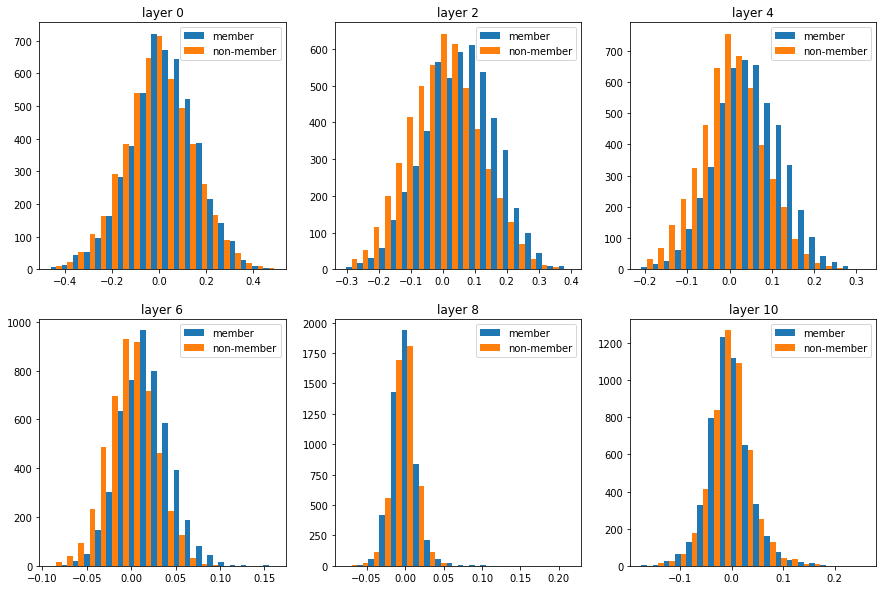

counting and norm combined ACC:0.8530677838535267


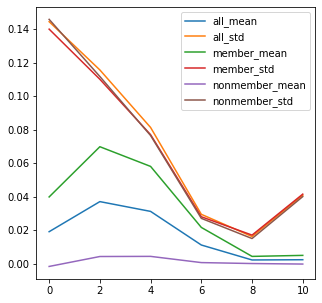

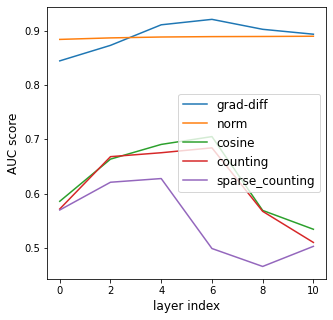

epoch: 240
(10000, 12, 24)


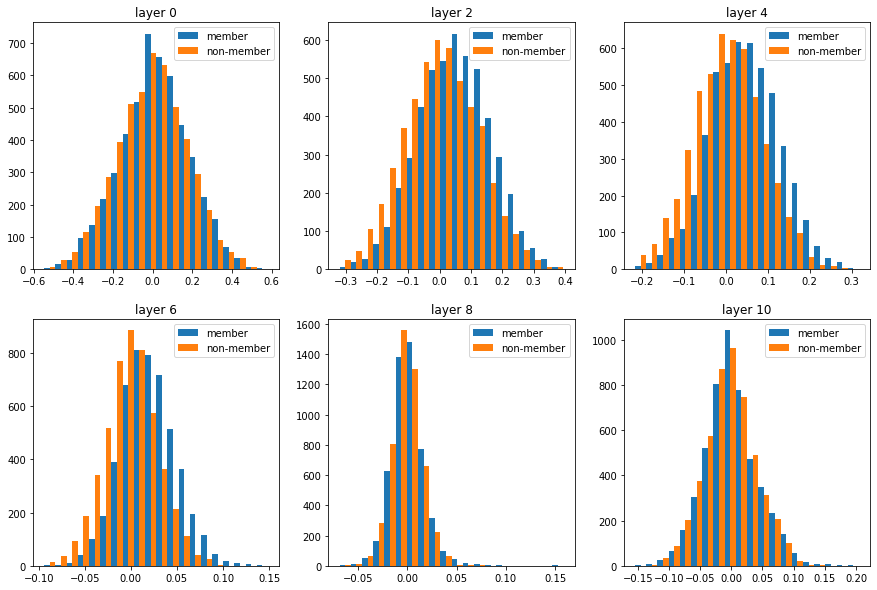

counting and norm combined ACC:0.8521217357910906


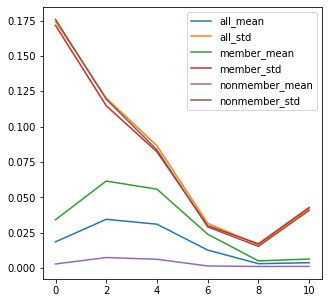

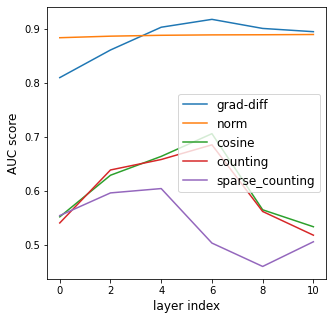

epoch: 250
(10000, 12, 24)


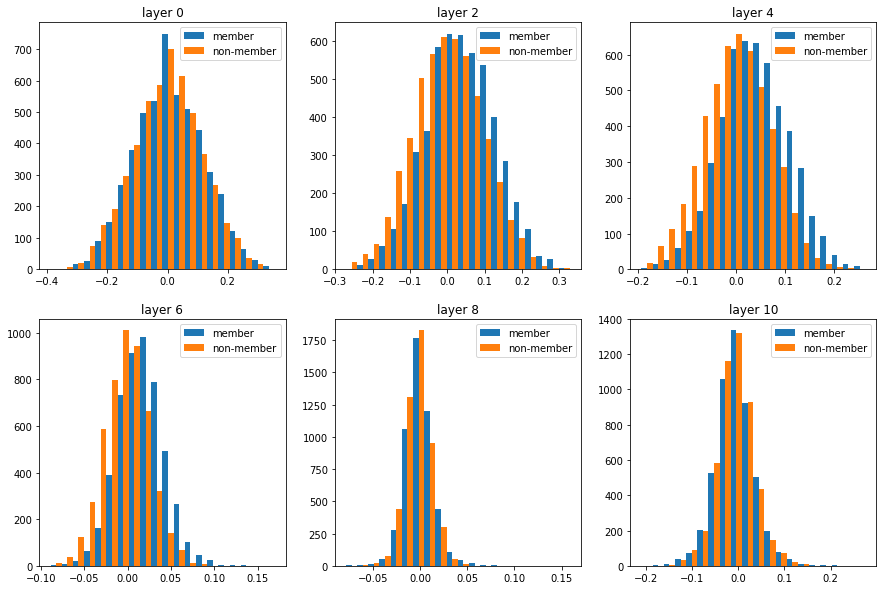

counting and norm combined ACC:0.8542828783626595


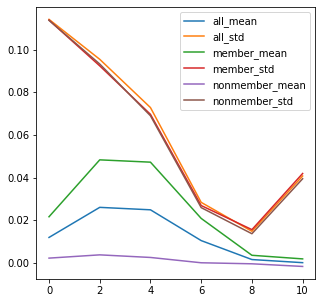

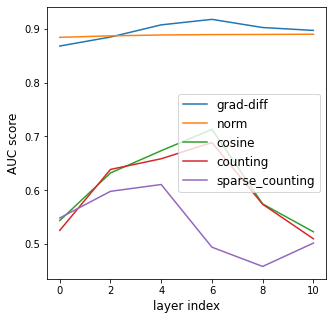

epoch: 260
(10000, 12, 24)


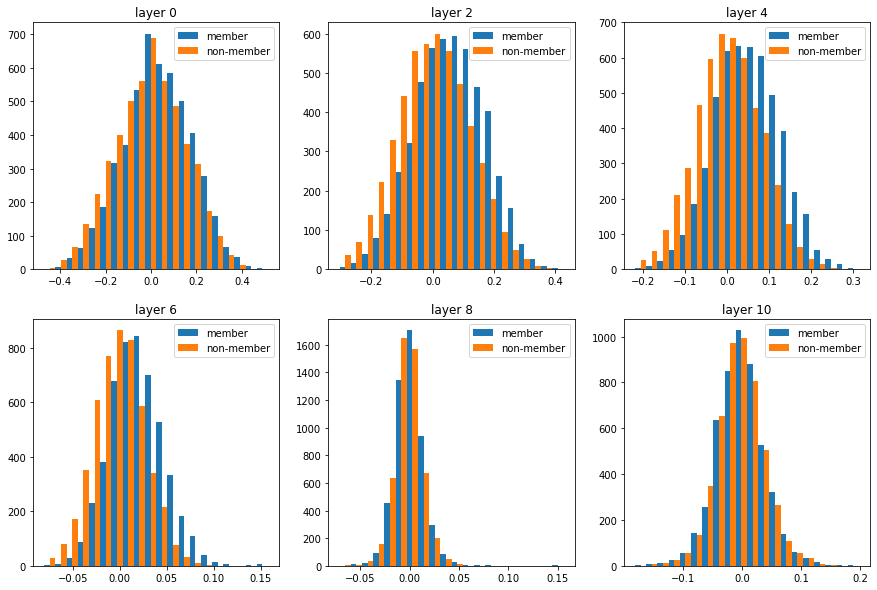

counting and norm combined ACC:0.8505359050373873


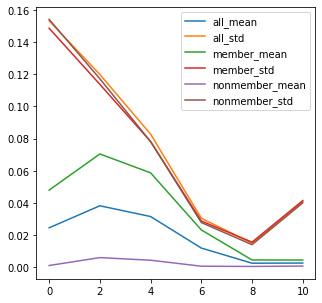

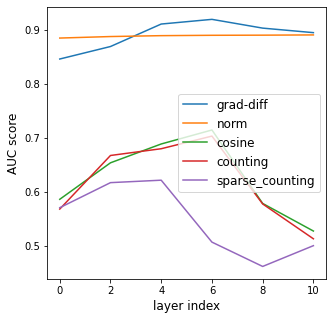

epoch: 270
(10000, 12, 24)


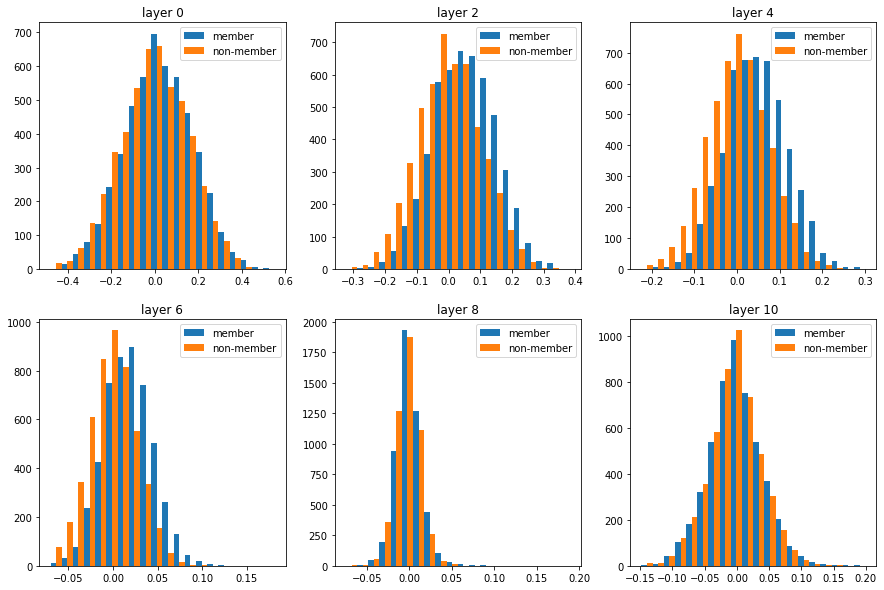

counting and norm combined ACC:0.8545488727819646


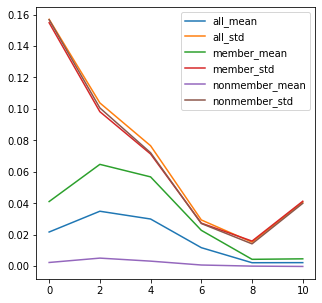

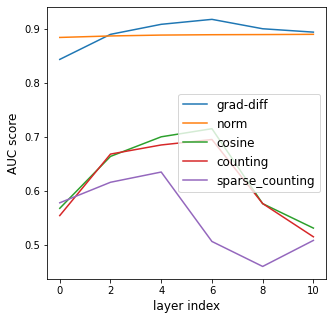

epoch: 280
(10000, 12, 24)


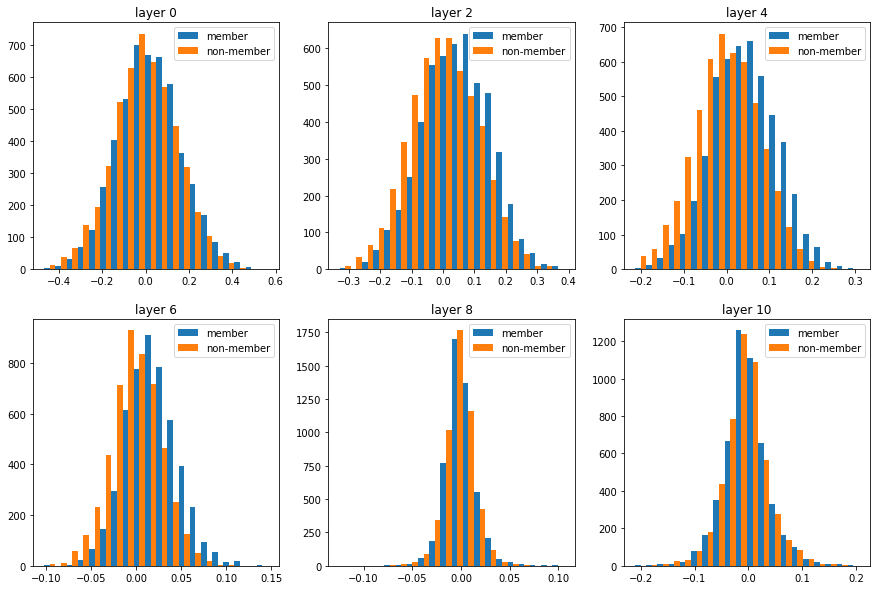

counting and norm combined ACC:0.8515311049799072


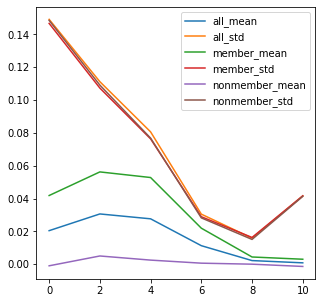

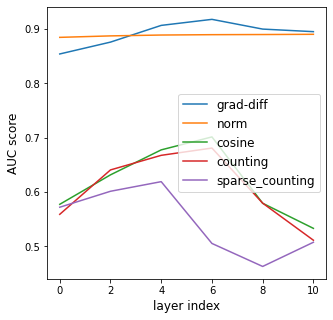

epoch: 290
(10000, 12, 24)


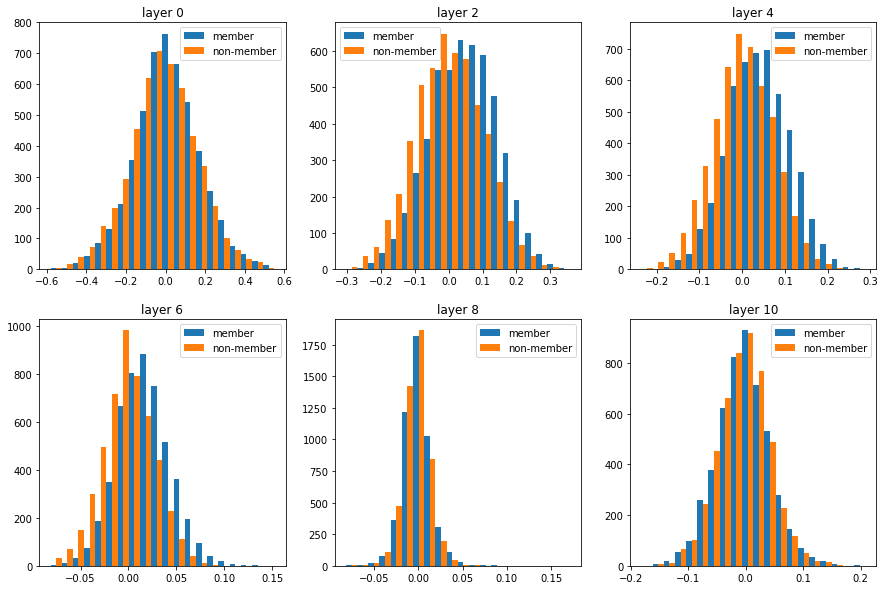

counting and norm combined ACC:0.8595720990452564


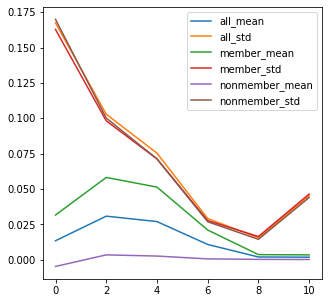

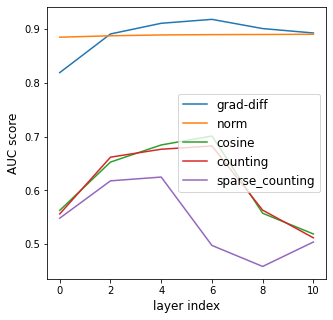

epoch: 300
(10000, 12, 24)


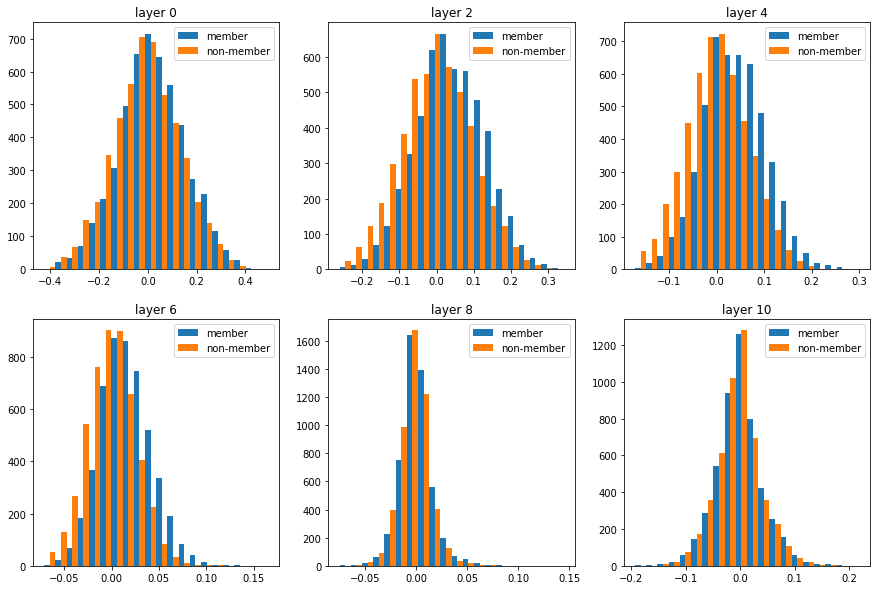

counting and norm combined ACC:0.8579237071172555


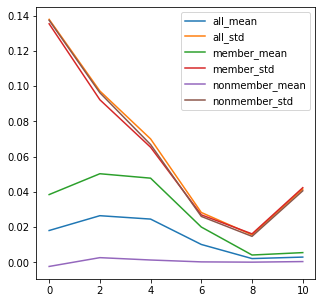

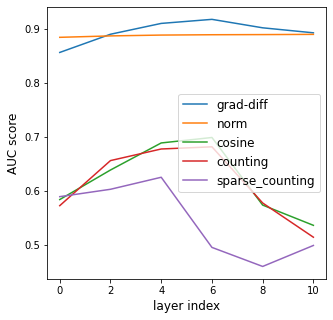

In [26]:
epochs = (np.arange(30)+1)*10
layer_analysis(epochs[-10:],5000,12,5000,'alexnet','cifar100',name_prefix='/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_non_member_single_epoch_0b_',
               special_layers=[0,2,4,6,8,10])

epoch: 210
(10000, 12, 24)


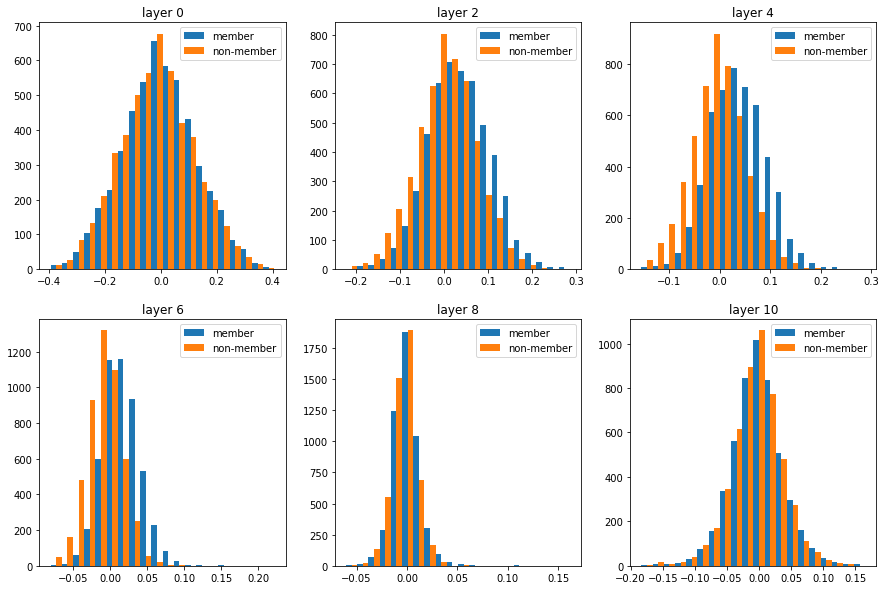

counting and norm combined ACC:0.5171370943548197


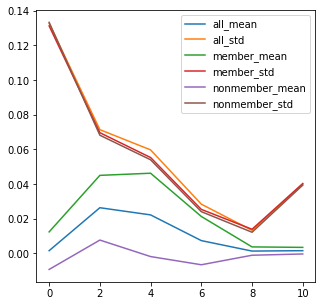

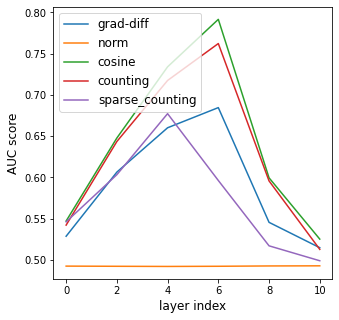

epoch: 220
(10000, 12, 24)


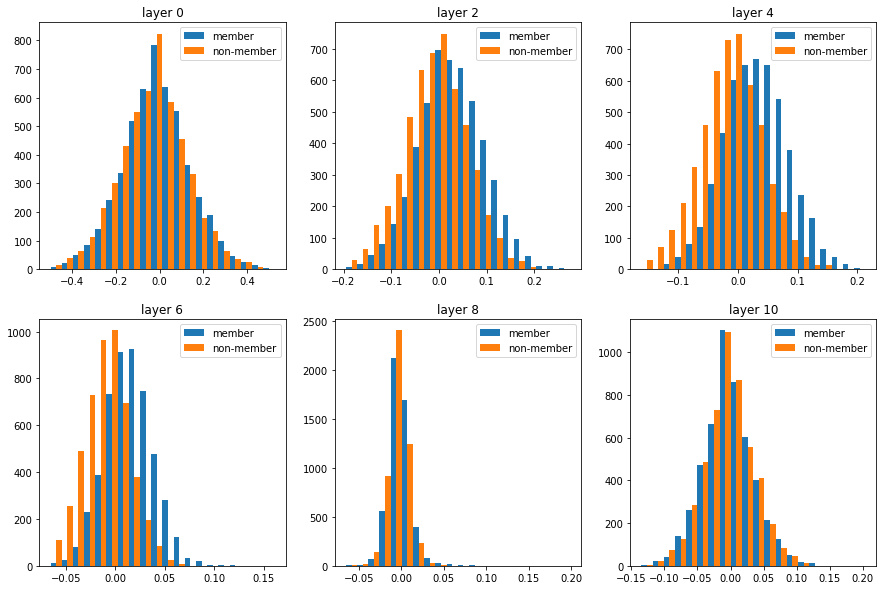

counting and norm combined ACC:0.5221139416488396


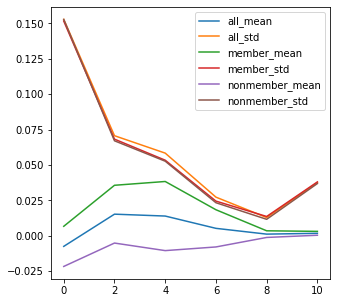

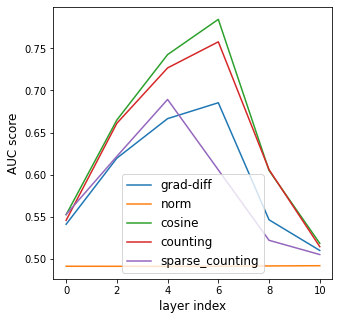

epoch: 230
(10000, 12, 24)


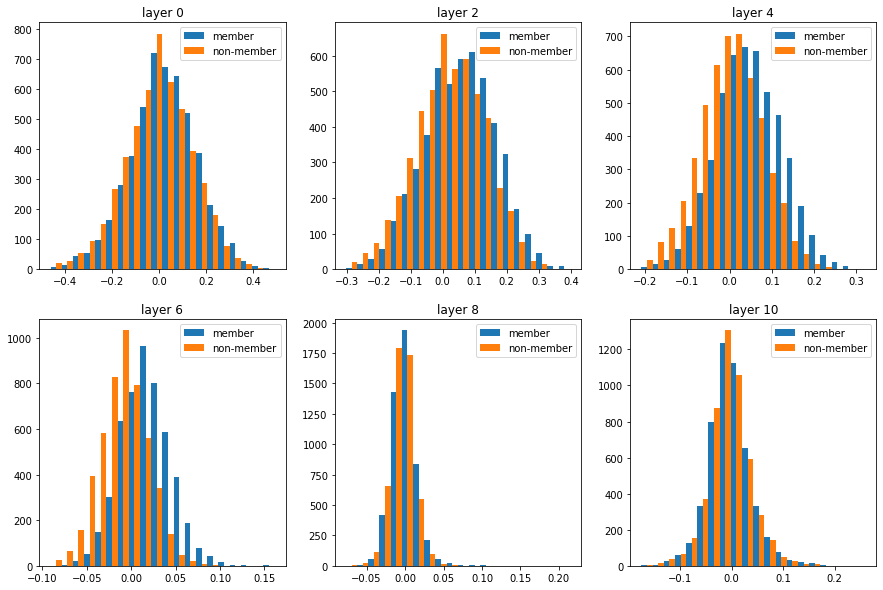

counting and norm combined ACC:0.5124687099796258


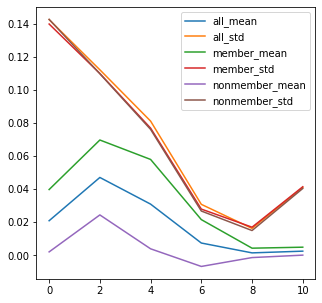

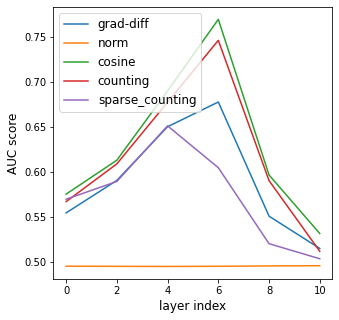

epoch: 240
(10000, 12, 24)


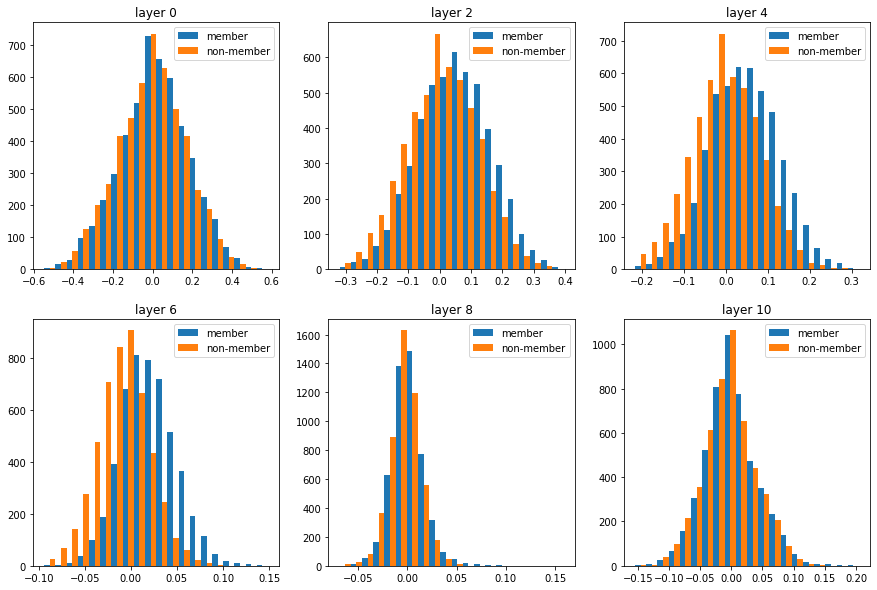

counting and norm combined ACC:0.5183589954301515


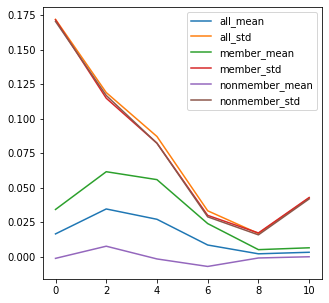

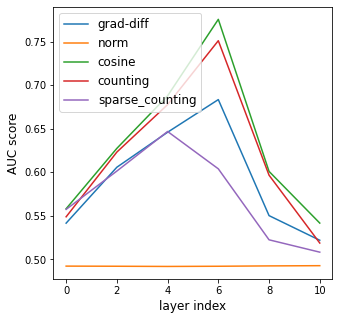

epoch: 250
(10000, 12, 24)


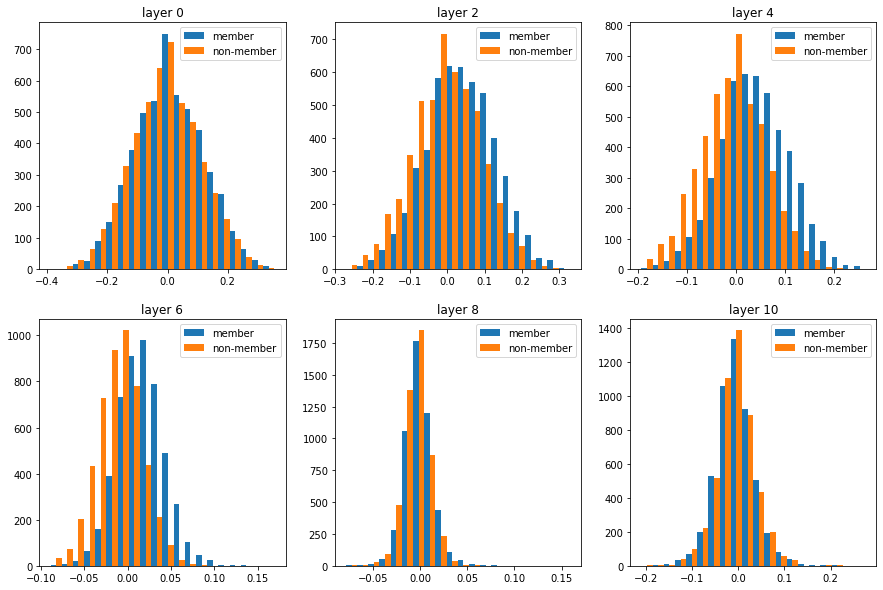

counting and norm combined ACC:0.5121099169445236


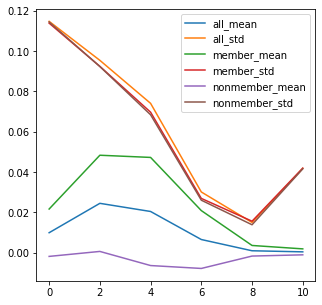

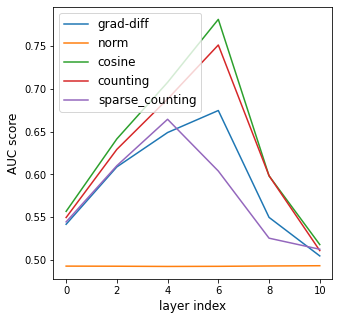

epoch: 260
(10000, 12, 24)


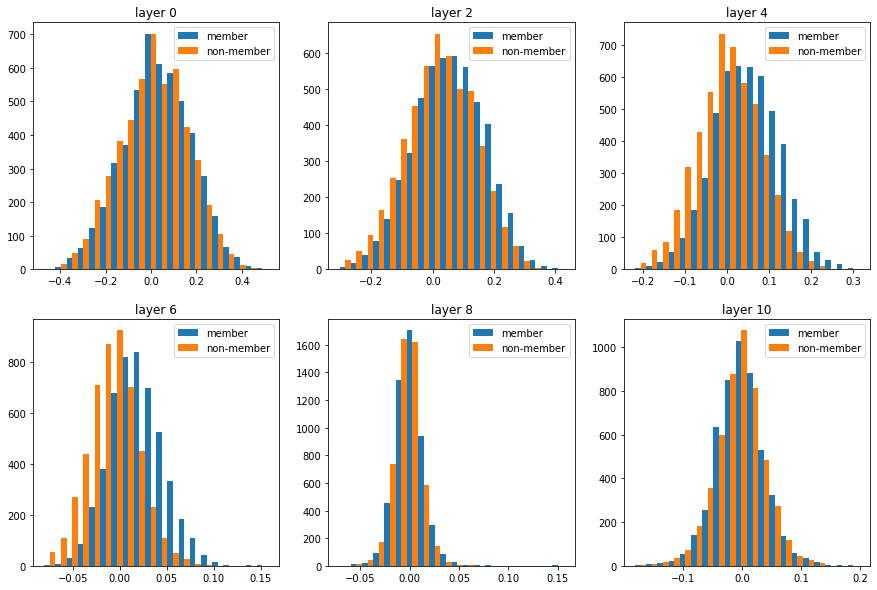

counting and norm combined ACC:0.5137621031817509


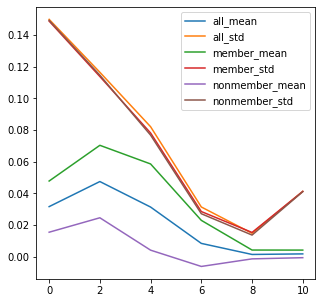

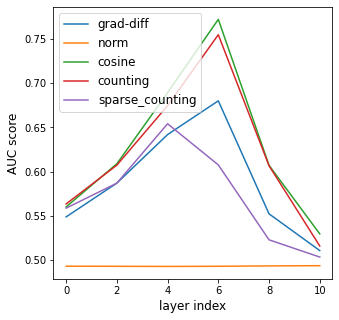

epoch: 270
(10000, 12, 24)


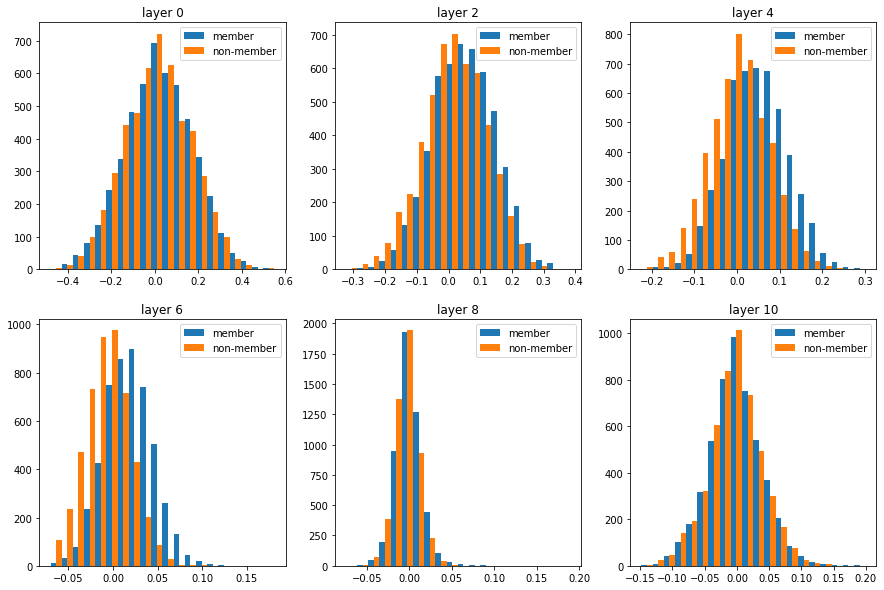

counting and norm combined ACC:0.5157735464459806


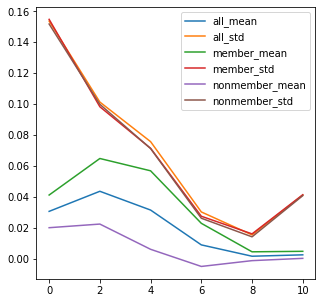

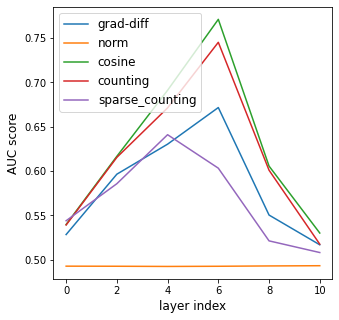

epoch: 280
(10000, 12, 24)


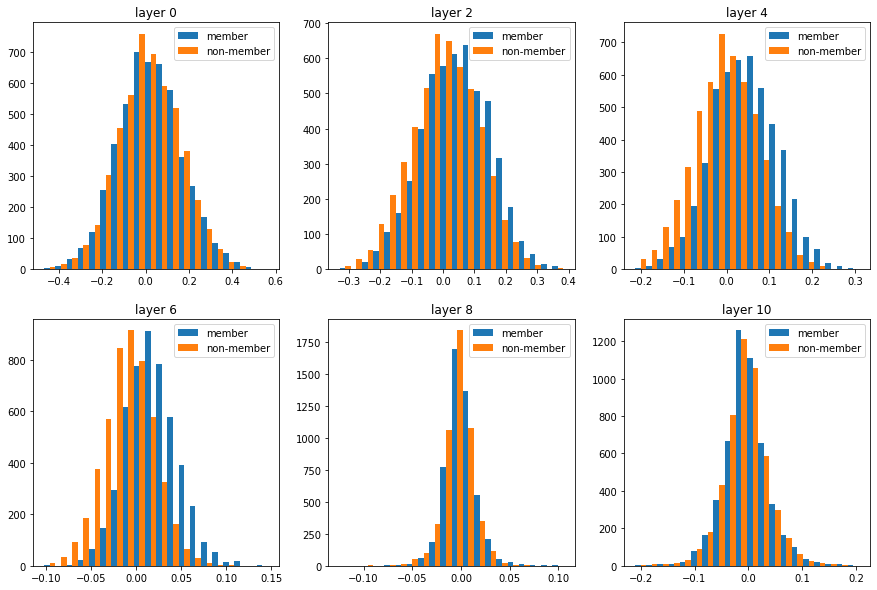

counting and norm combined ACC:0.512349778368085


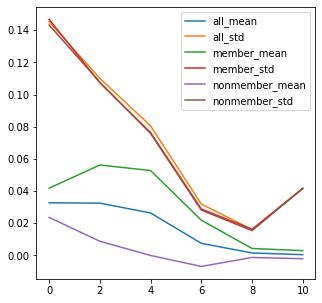

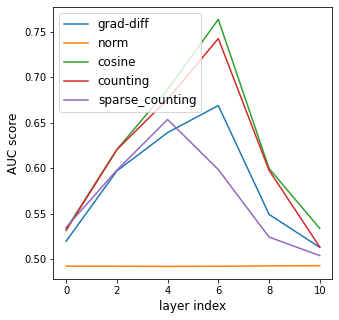

epoch: 290
(10000, 12, 24)


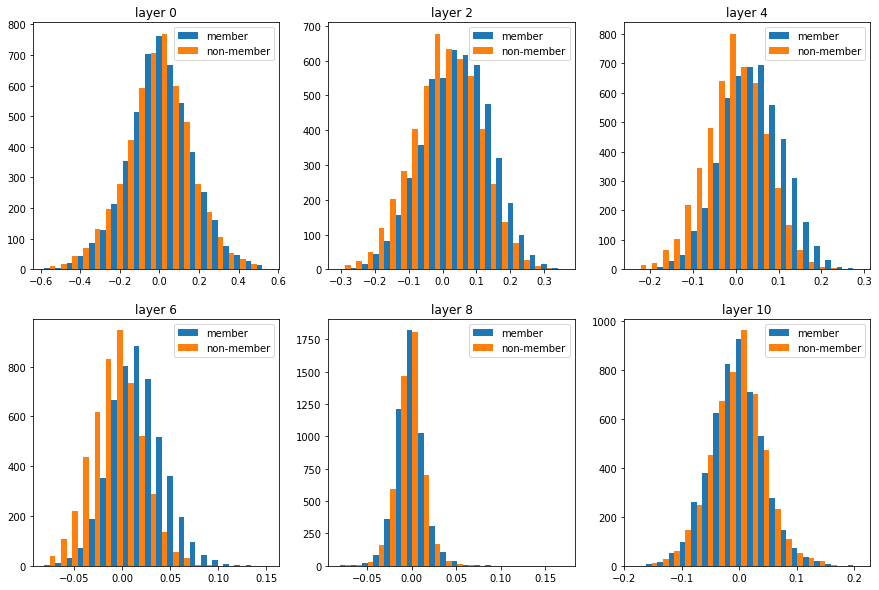

counting and norm combined ACC:0.512060286711842


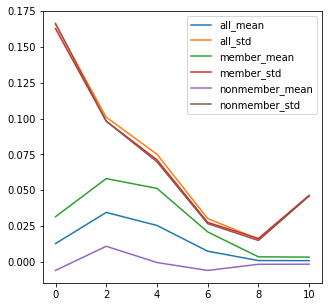

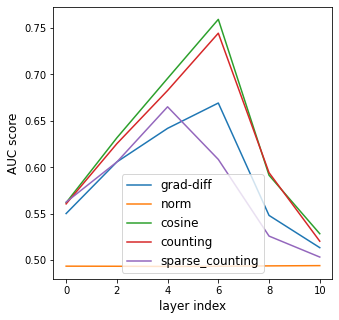

epoch: 300
(10000, 12, 24)


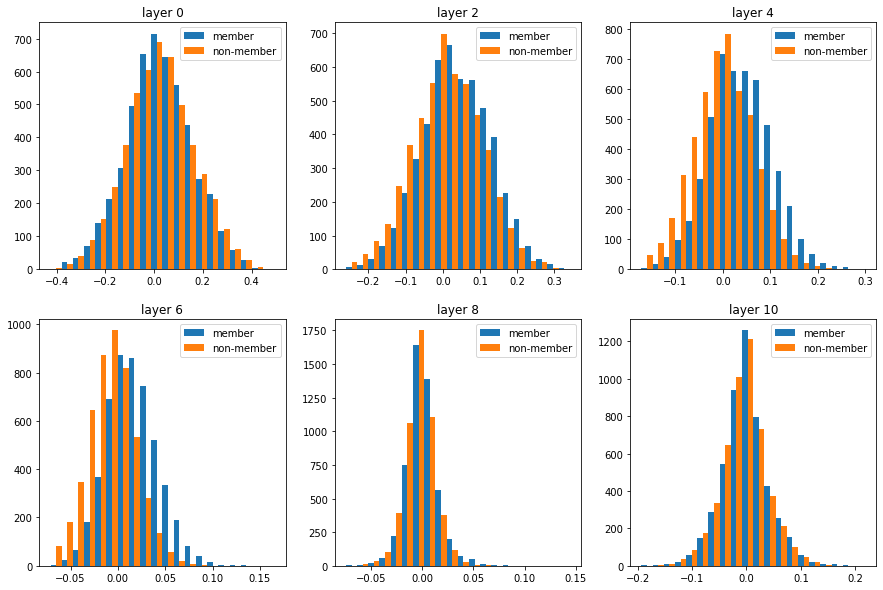

counting and norm combined ACC:0.5148380593522375


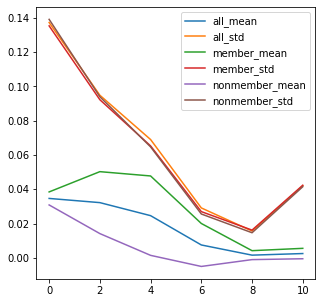

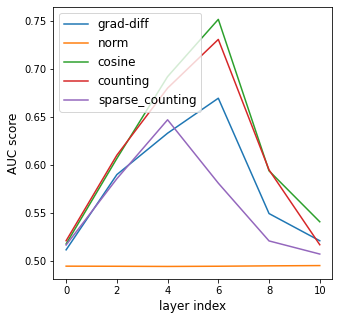

In [7]:
epochs = (np.arange(30)+1)*10
layer_analysis(epochs[-10:],5000,12,5000,'alexnet','cifar100',name_prefix='/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_cross_member_single_epoch_0b_',
               special_layers=[0,2,4,6,8,10])

epoch: 210
(10000, 12, 24)


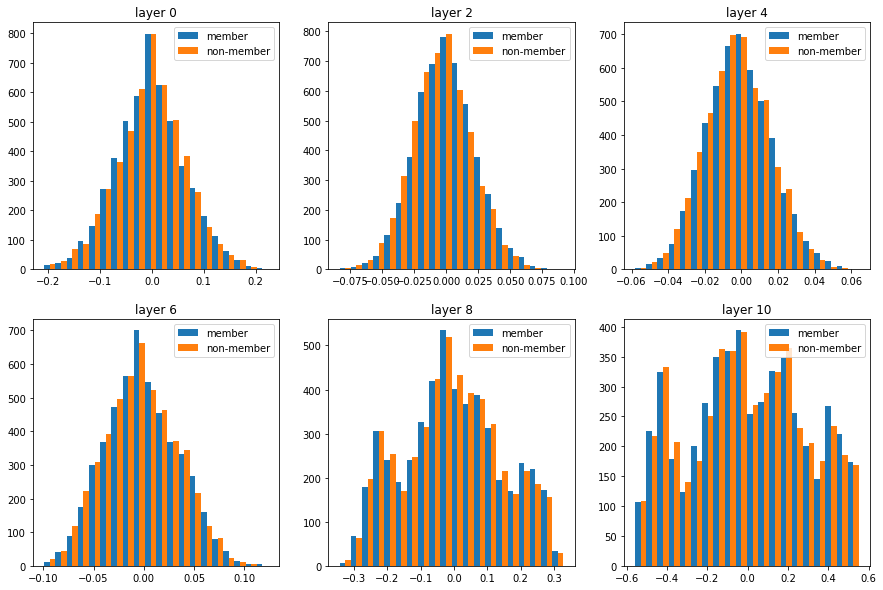

counting and norm combined ACC:0.5048867671789917


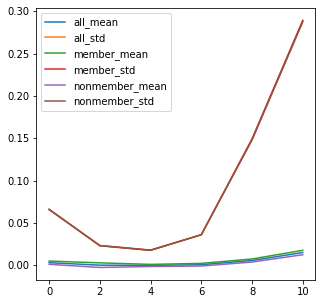

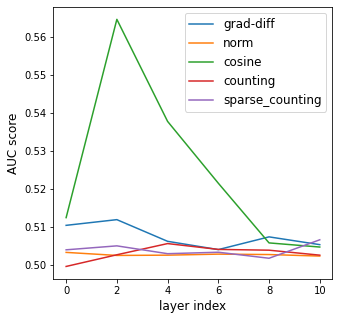

epoch: 220
(10000, 12, 24)


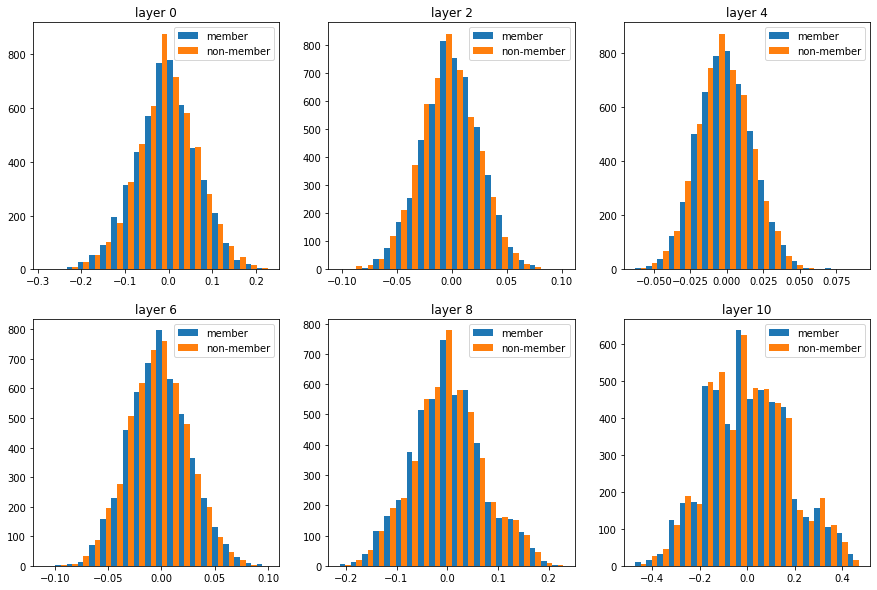

counting and norm combined ACC:0.5069414498921961


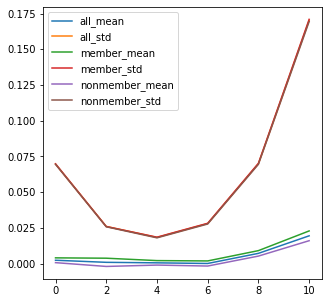

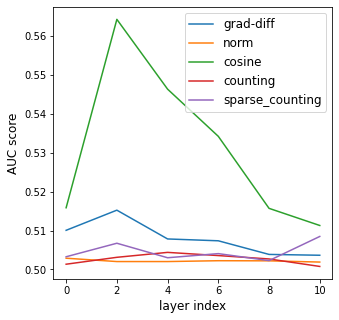

epoch: 230
(10000, 12, 24)


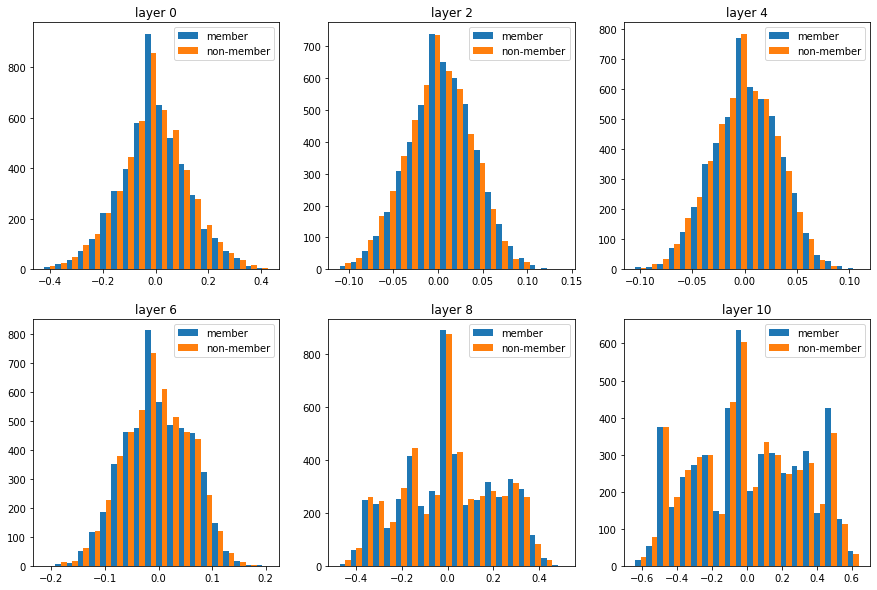

counting and norm combined ACC:0.51392089093702


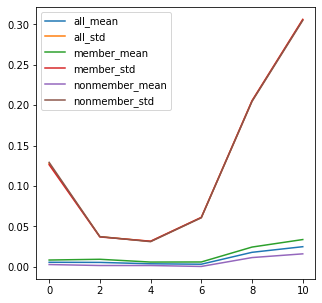

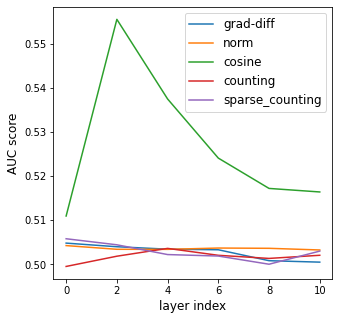

epoch: 240
(10000, 12, 24)


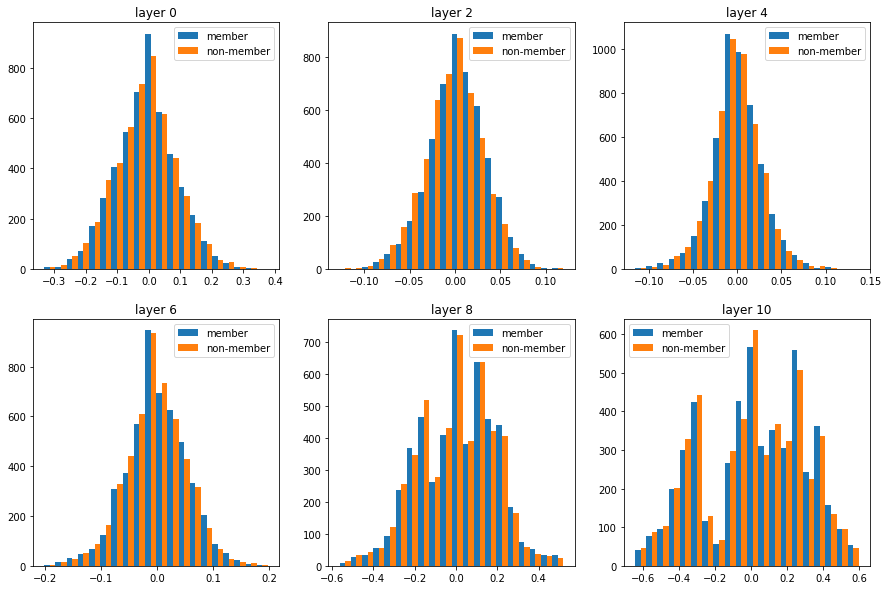

counting and norm combined ACC:0.5062144049740848


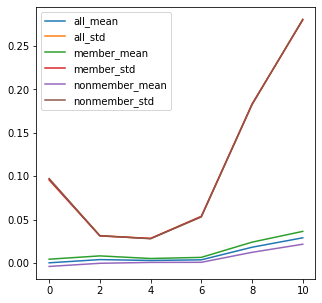

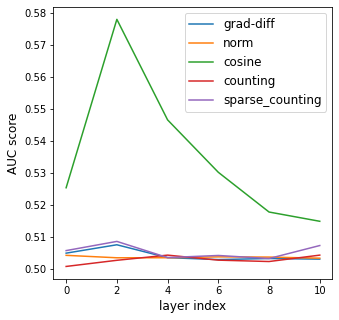

epoch: 250
(10000, 12, 24)


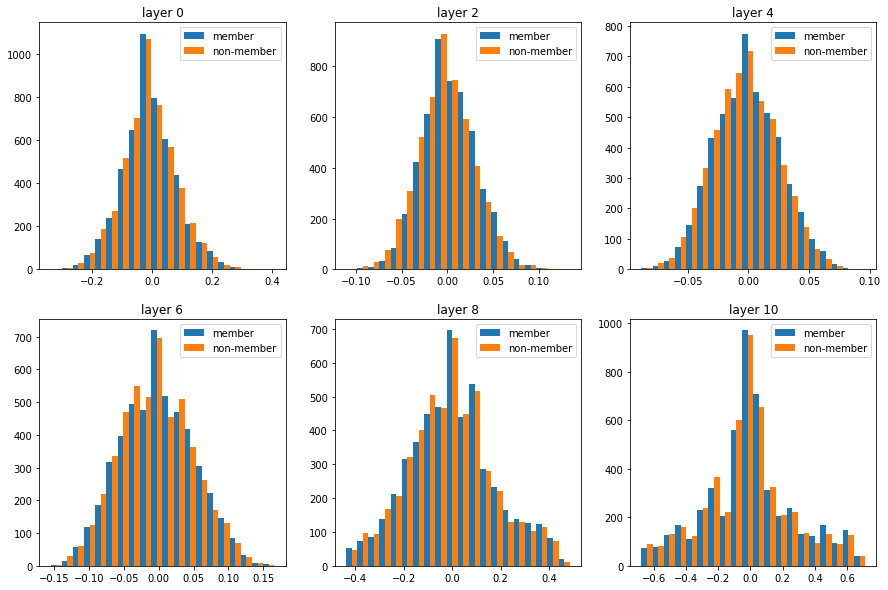

counting and norm combined ACC:0.5073715019367193


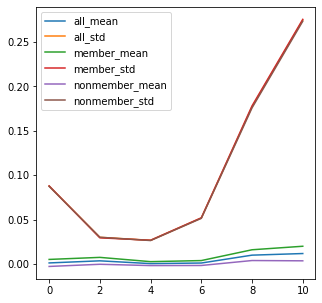

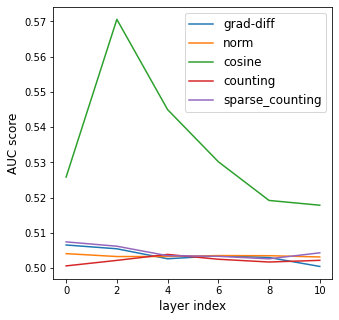

epoch: 260
(10000, 12, 24)


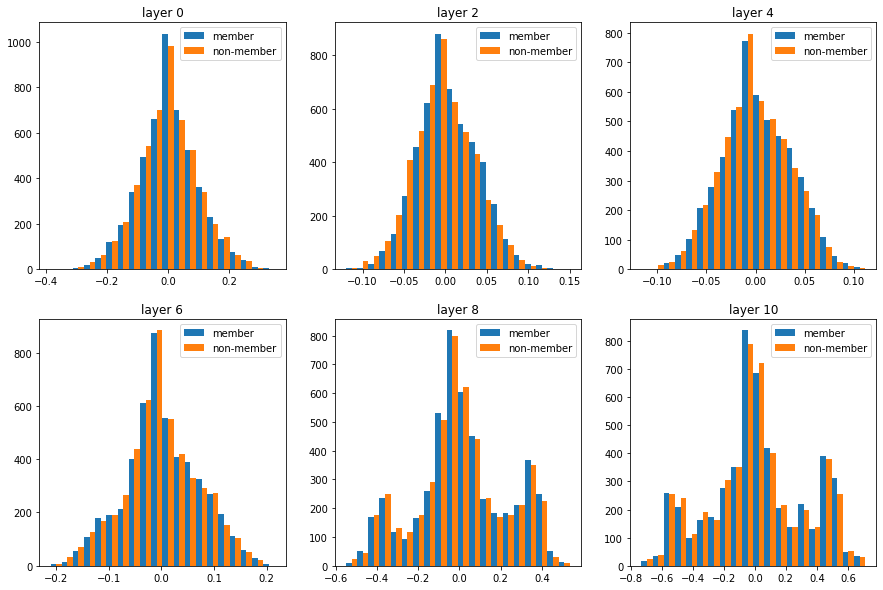

counting and norm combined ACC:0.5084814699198501


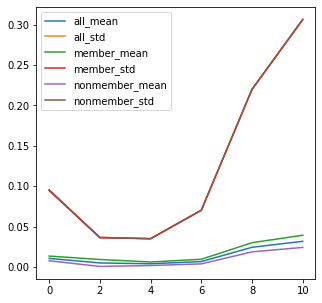

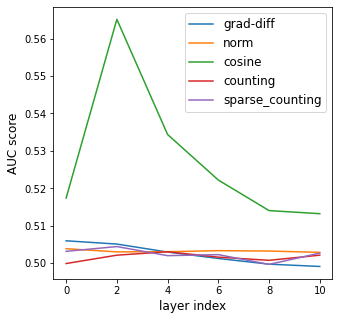

epoch: 270
(10000, 12, 24)


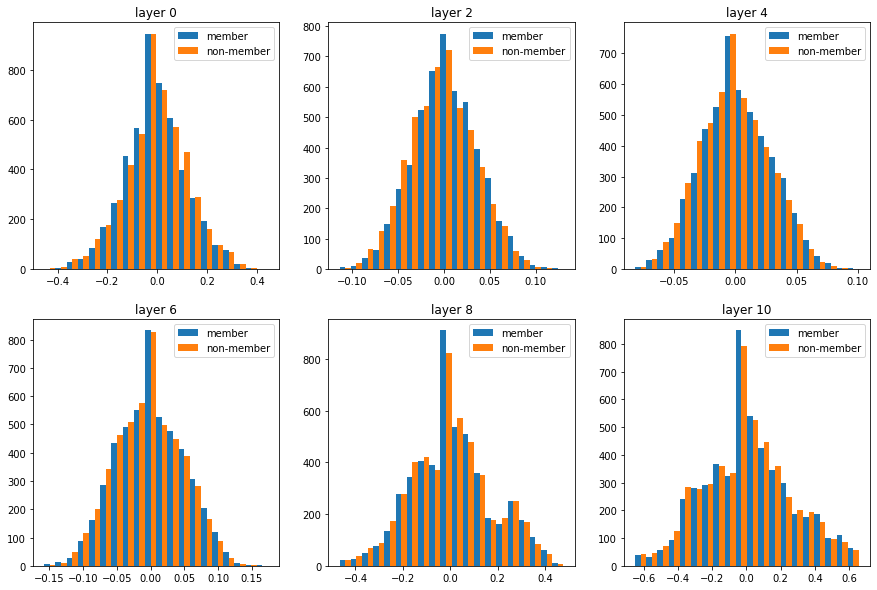

counting and norm combined ACC:0.5121627176288205


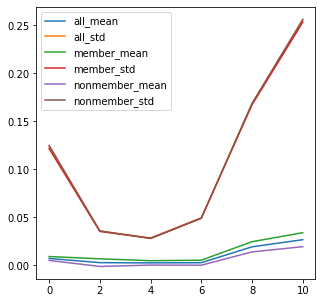

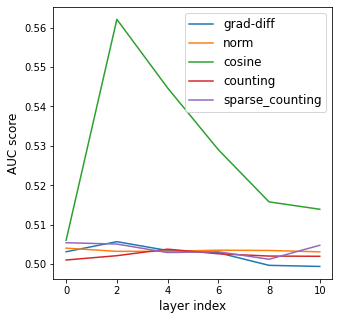

epoch: 280
(10000, 12, 24)


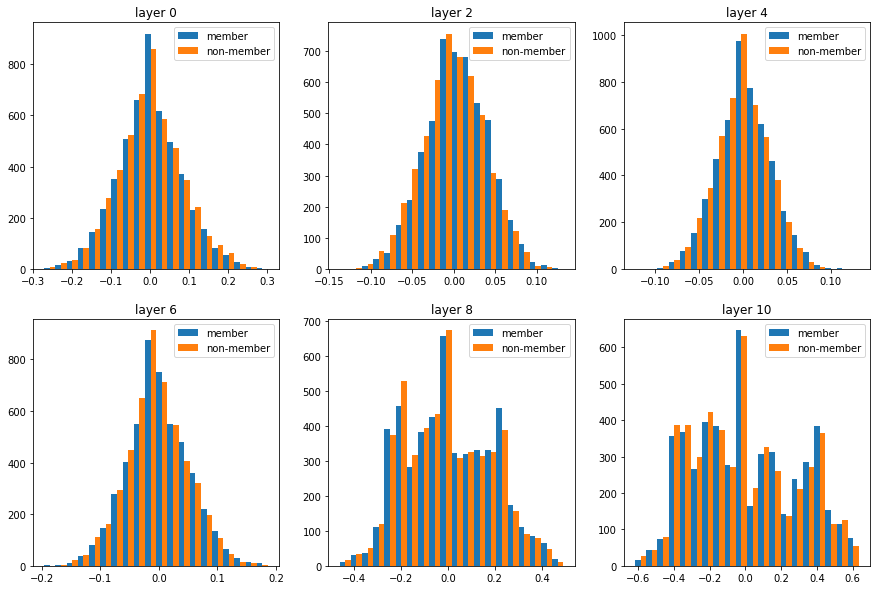

counting and norm combined ACC:0.5144046000496721


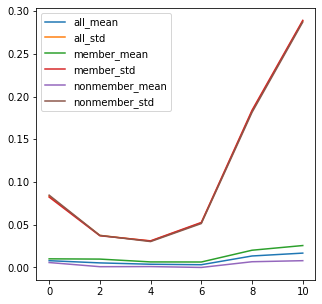

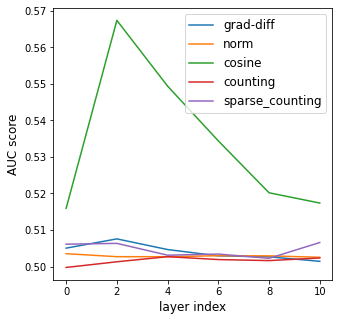

epoch: 290
(10000, 12, 24)


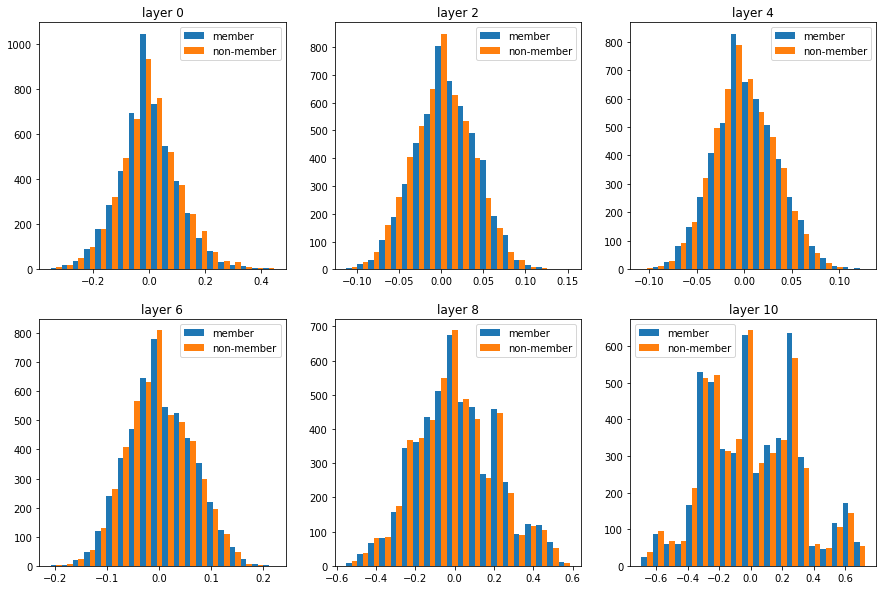

counting and norm combined ACC:0.509617618577347


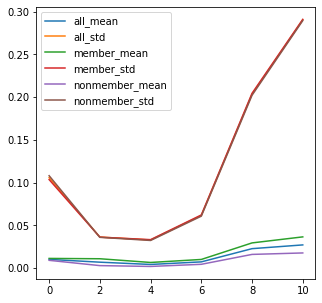

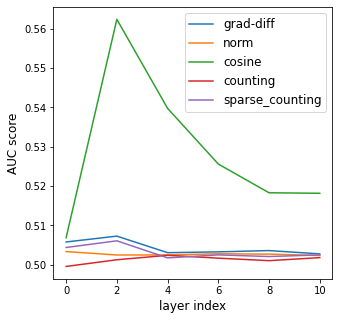

epoch: 300
(10000, 12, 24)


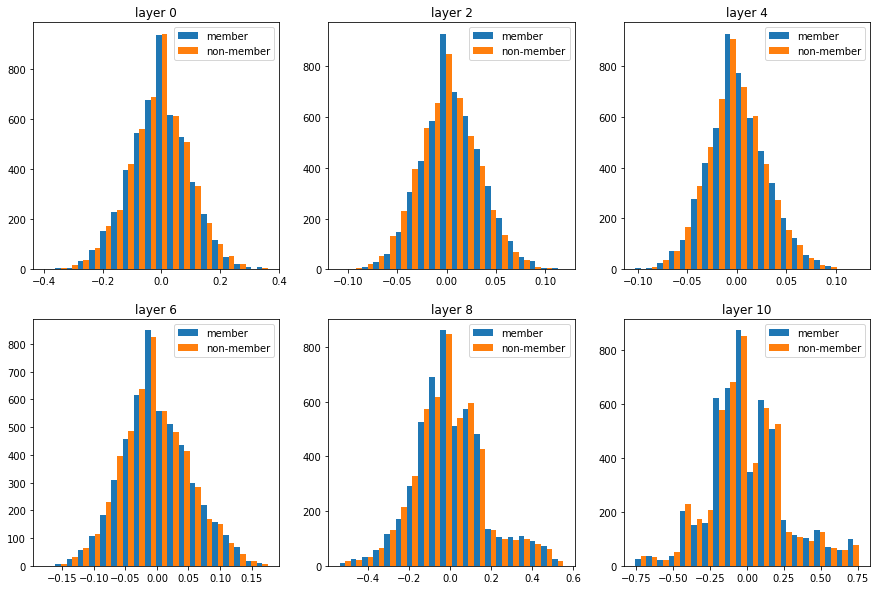

counting and norm combined ACC:0.5059868636227189


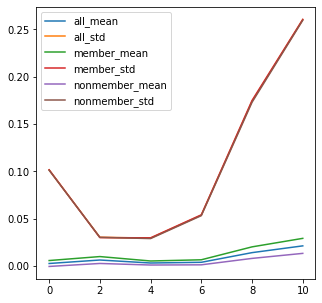

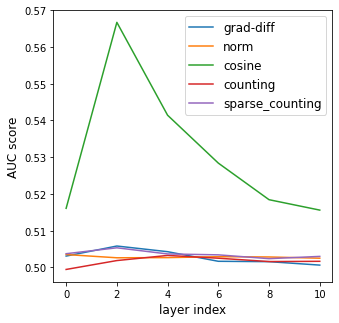

In [8]:
epochs = (np.arange(30)+1)*10
layer_analysis(epochs[-10:],5000,12,5000,'alexnet','cifar10',name_prefix='/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_cross_member_single_epoch',
               special_layers=[0,2,4,6,8,10])

epoch: 210
(10000, 12, 24)


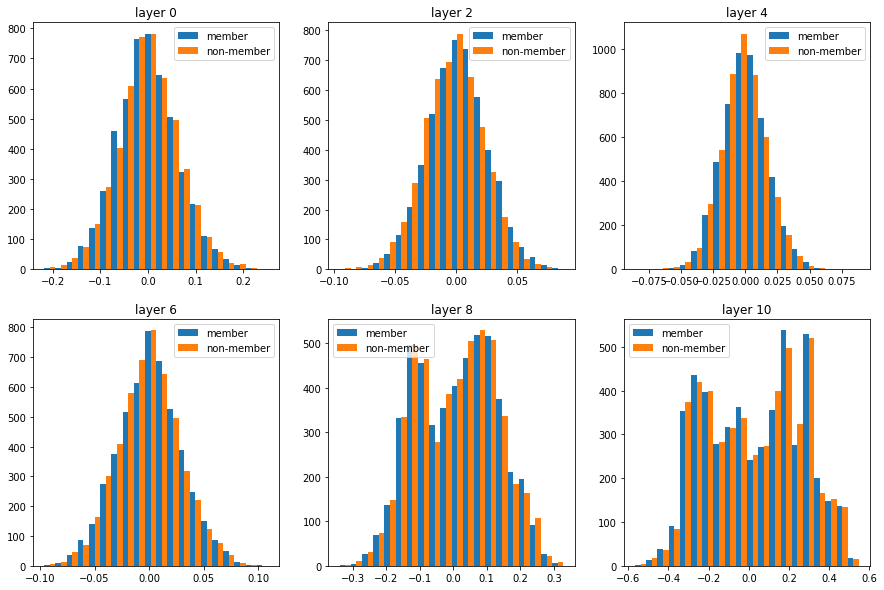

counting and norm combined ACC:0.5173186524517636


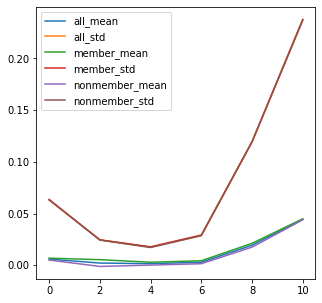

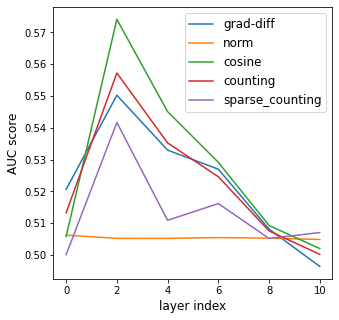

epoch: 220
(10000, 12, 24)


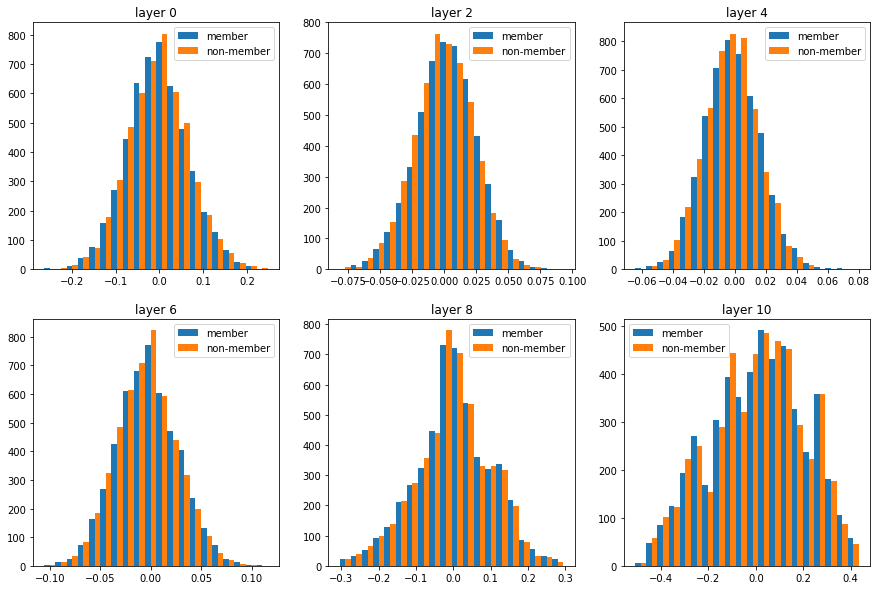

counting and norm combined ACC:0.5115041512100336


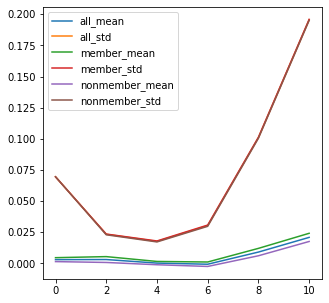

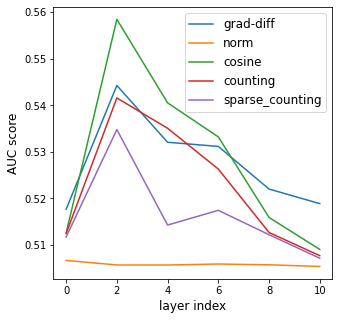

epoch: 230
(10000, 12, 24)


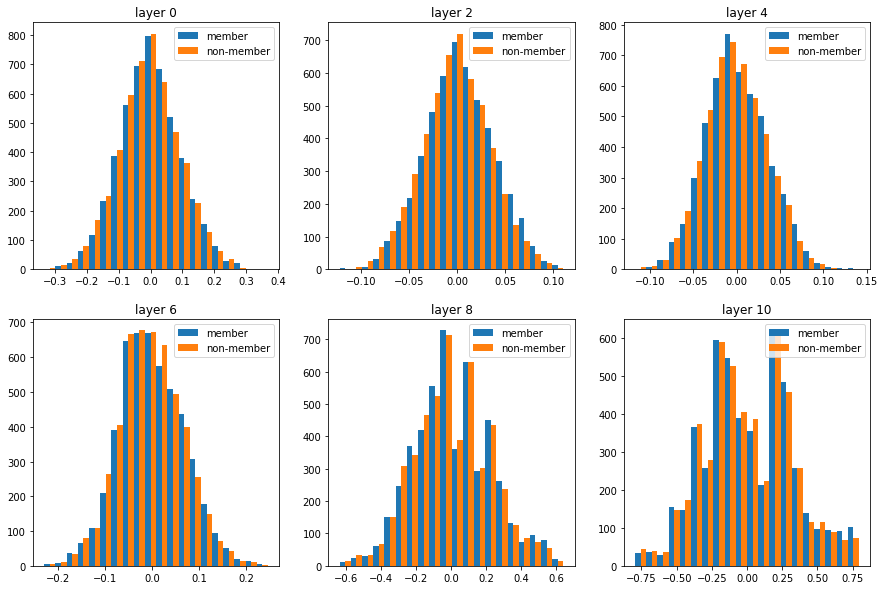

counting and norm combined ACC:0.5134594456180782


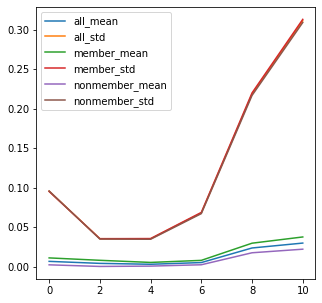

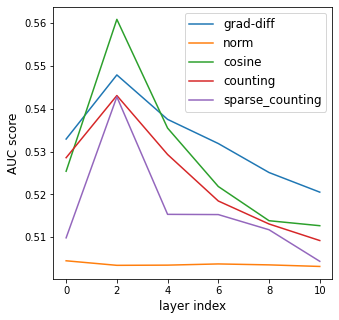

epoch: 240
(10000, 12, 24)


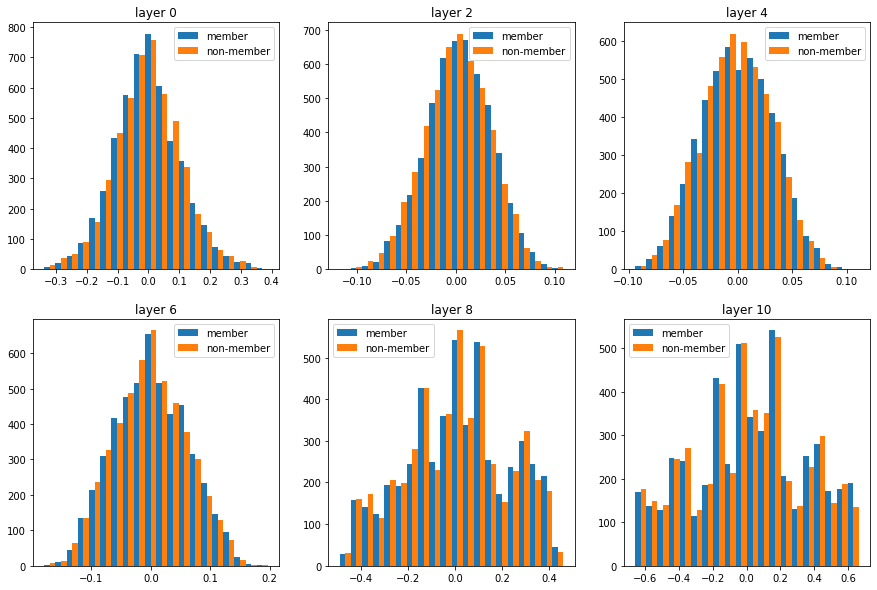

counting and norm combined ACC:0.5196663807411311


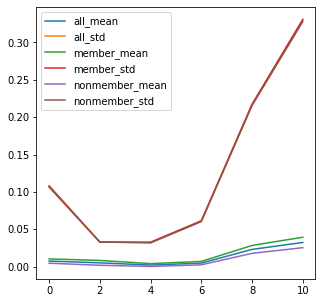

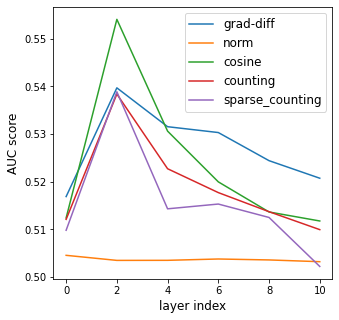

epoch: 250
(10000, 12, 24)


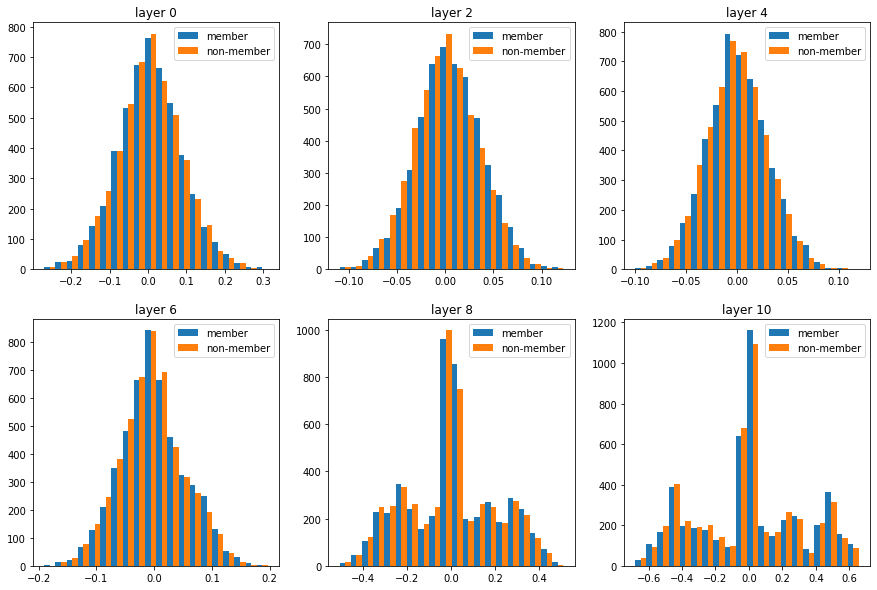

counting and norm combined ACC:0.5117476776572039


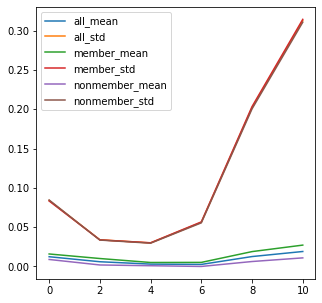

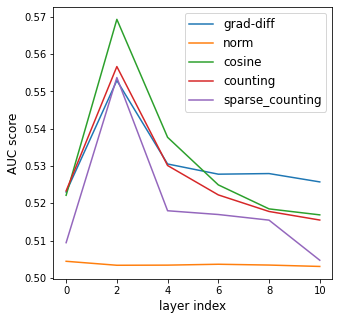

epoch: 260
(10000, 12, 24)


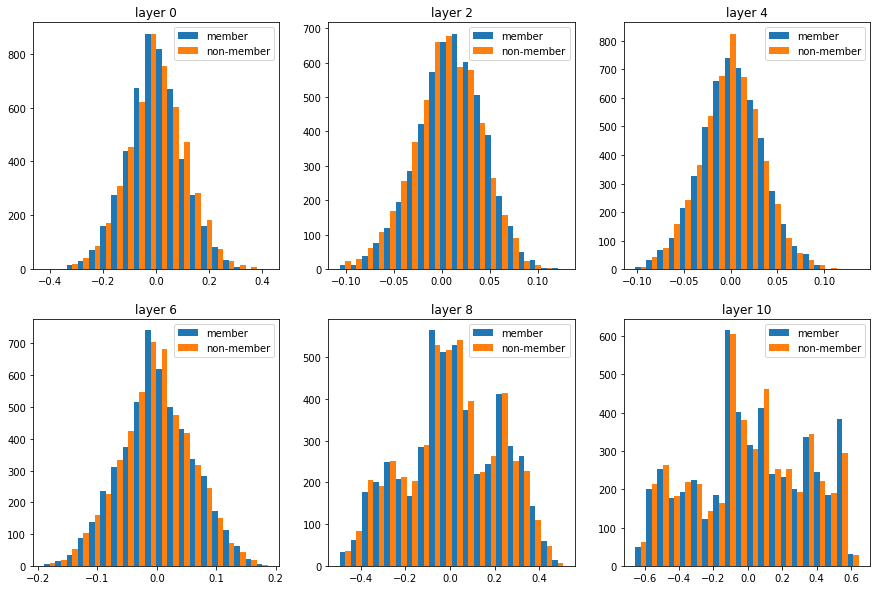

counting and norm combined ACC:0.5108561669479469


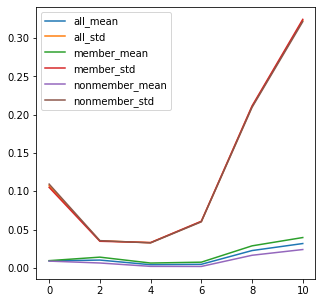

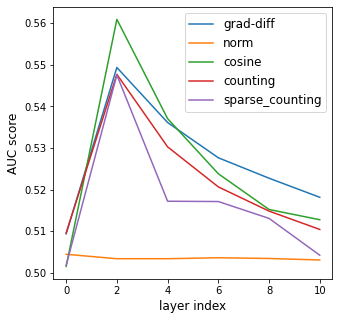

epoch: 270
(10000, 12, 24)


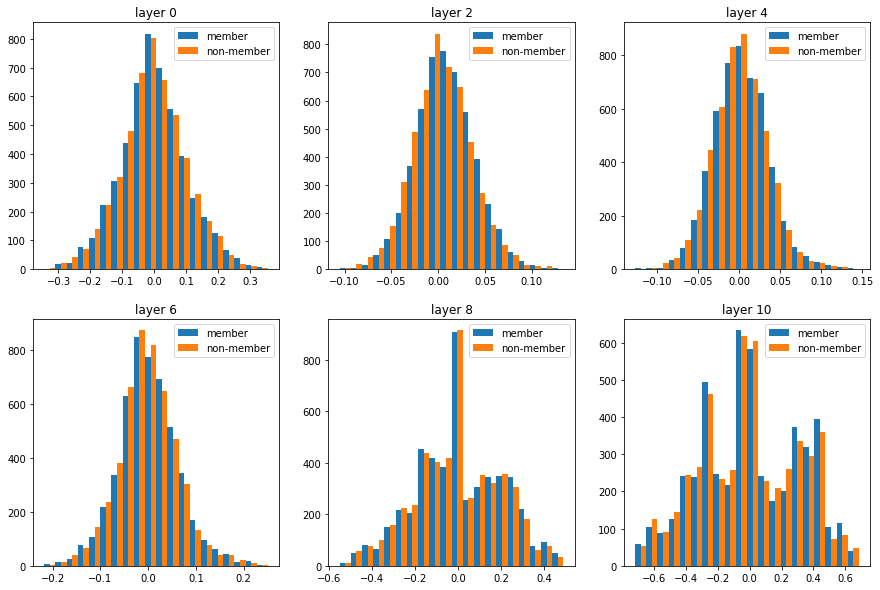

counting and norm combined ACC:0.5098526187771039


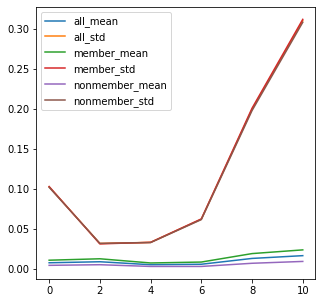

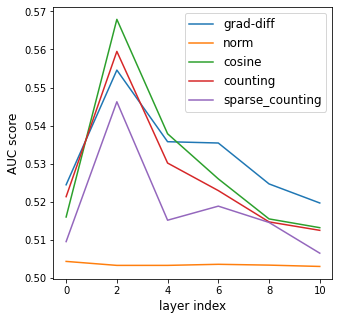

epoch: 280
(10000, 12, 24)


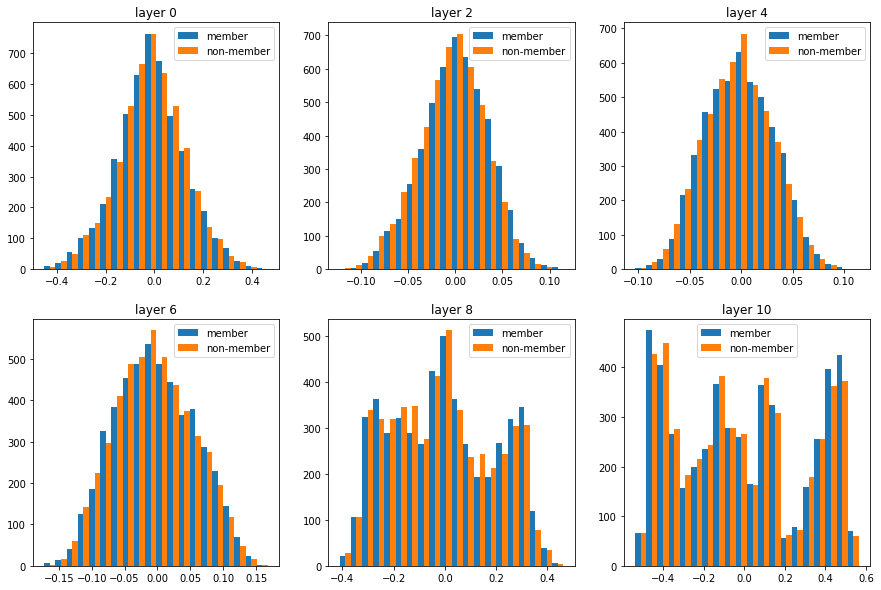

counting and norm combined ACC:0.5081996749828307


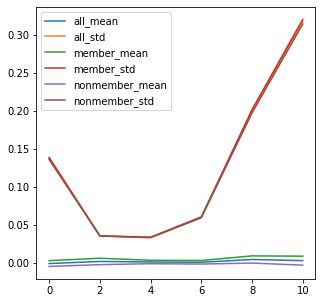

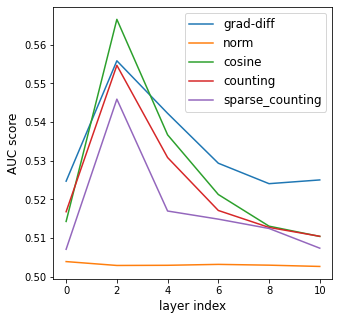

epoch: 290
(10000, 12, 24)


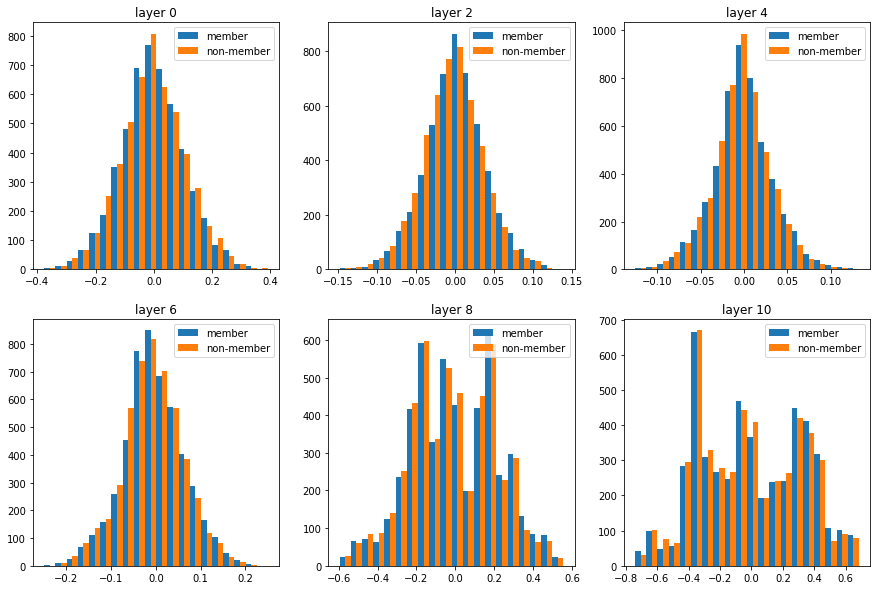

counting and norm combined ACC:0.5205086401355998


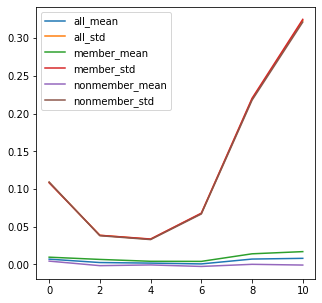

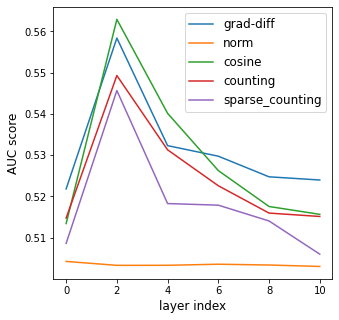

epoch: 300
(10000, 12, 24)


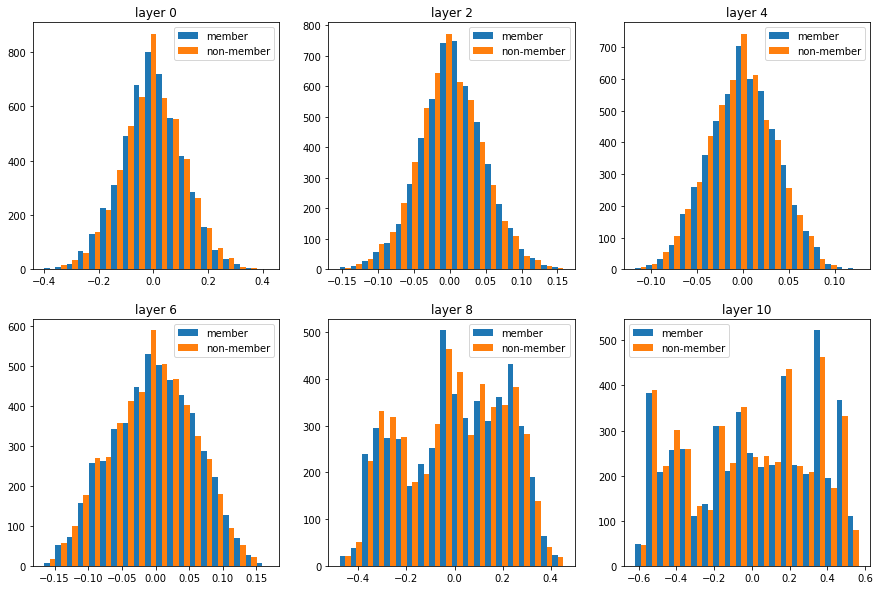

counting and norm combined ACC:0.5185271201114766


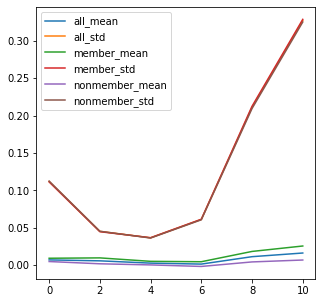

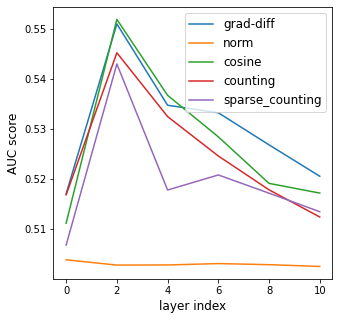

In [9]:
epochs = (np.arange(30)+1)*10
layer_analysis(epochs[-10:],5000,12,5000,'alexnet','cifar10',name_prefix='/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_cross_member_single_epoch_0b_',
               special_layers=[0,2,4,6,8,10])